# IMPORTATION

In [1]:
import urllib.request
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np
import math
import folium
from sklearn.cluster import DBSCAN
from folium.plugins import MarkerCluster
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, silhouette_samples
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import calinski_harabasz_score

# General treatment

In [2]:
url = 'https://data.gov.il/api/3/action/datastore_search?resource_id=e356ab12-0284-4bdd-a9f8-22b11d517da0&limit=10404'
with urllib.request.urlopen(url) as fileobj:
    data = json.loads(fileobj.read().decode('utf-8'))

records = data['result']['records']

data_list = []
for record in records:
    data_list.append(record)
df = pd.DataFrame(data_list)
df.head(3)

_id  pk_teuna_fikt  sug_tik  THUM_GEOGRAFI  SUG_DEREH  SEMEL_YISHUV REHOV1  \
0    1     2021000826        1              1          2          6200    201   
1    2     2021005117        1              1          4             0   None   
2    3     2021013450        1              1          4             0   None   

  REHOV2 BAYIT ZOMET_IRONI  ... MEKOM_HAZIYA KIVUN_HAZIYA MAHOZ NAFA  \
0   None    56        None  ...            0            9     5   51   
1   None  None        None  ...            0            9     2   29   
2   None  None        None  ...            0            9     2   24   

   EZOR_TIVI  MAAMAD_MINIZIPALI  ZURAT_ISHUV  STATUS_IGUN       X       Y  
0        513                  0           14            1  176369  659329  
1        291                 99           99            1  271726  795545  
2        241                 99           99            1  230240  751540  

[3 rows x 46 columns]

In [3]:
df = df.drop(['_id',"THUM_GEOGRAFI","sug_tik",'SEMEL_YISHUV','YEHIDA',"BAYIT","KM","HAD_MASLUL","RAV_MASLUL","SUG_EZEM","MERHAK_EZEM",'LO_HAZA', 'OFEN_HAZIYA', 'MEKOM_HAZIYA', "KIVUN_HAZIYA","STATUS_IGUN",'REHOV1', 'REHOV2','MAHOZ','NAFA','MAAMAD_MINIZIPALI','ZURAT_ISHUV','SUG_YOM','YOM_LAYLA','YOM_BASHAVUA','HODESH_TEUNA','SHNAT_TEUNA','SHAA'] , axis=1)

In [4]:
column_mapping = {
    'pk_teuna_fikt': 'accident_number',
    'SUG_DEREH': 'road_type',
    'SEMEL_YISHUV': 'settlement_symbol',
    'ZOMET_IRONI': 'municipal_crossroad',
    'KVISH1': 'road_number1',
    'KVISH2': 'road_number2',
    'ZOMET_LO_IRONI': 'not_municipal_crossroad',
    'YEHIDA': 'police_unit',
    'SHNAT_TEUNA': 'accident_year',
    'HODESH_TEUNA': 'accident_month',
    'SHAA': 'accident_hour',
    'SUG_YOM': 'day_type',
    'YOM_LAYLA': 'day_or_night',
    'YOM_BASHAVUA': 'accident_day',
    'HUMRAT_TEUNA': 'accident_severity',
    'SUG_TEUNA': 'accident_type',
    'TKINUT': 'road_condition',
    'ROHAV': 'road_width',
    'SIMUN_TIMRUR': 'road_sign',
    'TEURA': 'lighting',
    'MEZEG_AVIR': 'weather',
    'PNE_KVISH': 'road_surface',
    'MAHOZ': 'district',
    'NAFA': 'region',
    'MEHIRUT_MUTERET': 'speed_limit',
    'EZOR_TIVI': 'natural_area',
    'MAAMAD_MINIZIPALI': 'municipal_position',
    'ZURAT_ISHUV': 'settlement_form'
}

df.rename(columns=column_mapping, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10404 entries, 0 to 10403
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   accident_number          10404 non-null  int64 
 1   road_type                10404 non-null  int64 
 2   municipal_crossroad      3296 non-null   object
 3   road_number1             3540 non-null   object
 4   road_number2             3487 non-null   object
 5   not_municipal_crossroad  1454 non-null   object
 6   accident_severity        10404 non-null  int64 
 7   accident_type            10404 non-null  int64 
 8   speed_limit              10404 non-null  int64 
 9   road_condition           10404 non-null  int64 
 10  road_width               10404 non-null  int64 
 11  road_sign                10404 non-null  int64 
 12  lighting                 10404 non-null  int64 
 13  weather                  10404 non-null  int64 
 14  road_surface             10404 non-nul

In [6]:
def ITM2GRID(y, x):
    # Constantes
    false_n = 2885516.9488
    false_e = 219529.584
    k0 = 1.0000067
    a = 6378137
    b = 6356752.3141
    e = 0.0818191910428276
    esq = 0.00669438002290272
    lon0 = 0.61443473225468920
    lat0 = 0.55386965463774187
    dX = -48
    dY = 55
    dZ = 52

    # Calculs
    Nvr = y
    Evr = x
    M = (Nvr + false_n) / k0

    mu = M / (a * (1 - e * e / 4 - 3 * math.pow(e, 4) / 64 - 5 * math.pow(e, 6) / 256))
    ee = math.sqrt(1 - esq)
    e1 = (1 - ee) / (1 + ee)

    j1 = 3 * e1 / 2 - 27 * e1 * e1 * e1 / 32
    j2 = 21 * e1 * e1 / 16 - 55 * e1 * e1 * e1 * e1 / 32
    j3 = 151 * e1 * e1 * e1 / 96
    j4 = 1097 * e1 * e1 * e1 * e1 / 512

    fp = mu + j1 * math.sin(2 * mu) + j2 * math.sin(4 * mu) + j3 * math.sin(6 * mu) + j4 * math.sin(8 * mu)
    sinfp = math.sin(fp)
    cosfp = math.cos(fp)
    tanfp = sinfp / cosfp
    eg = (e * a / b)
    eg2 = eg * eg
    C1 = eg2 * cosfp * cosfp
    T1 = tanfp * tanfp
    R1 = a * (1 - e * e) / pow(1 - (e * sinfp) * (e * sinfp), 1.5)
    N1 = a / math.sqrt(1 - (e * sinfp) * (e * sinfp))
    D = (Evr - false_e) / (N1 * k0)
    Q1 = N1 * tanfp / R1
    Q2 = D * D / 2
    Q3 = (5 + 3 * T1 + 10 * C1 - 4 * C1 * C1 - 9 * eg2 * eg2) * (D * D * D * D) / 24
    Q4 = (61 + 90 * T1 + 298 * C1 + 45 * T1 * T1 - 3 * C1 * C1 - 252 * eg2 * eg2) * (D * D * D * D * D * D) / 720
    lat = fp - Q1 * (Q2 - Q3 + Q4)
    Q5 = D
    Q6 = (1 + 2 * T1 + C1) * (D * D * D) / 6
    Q7 = (5 - 2 * C1 + 28 * T1 - 3 * C1 * C1 + 8 * eg2 * eg2 + 24 * T1 * T1) * (D * D * D * D * D) / 120
    lon = lon0 + (Q5 - Q6 + Q7) / cosfp

    # Molodensky WGS80 -> GRS84
    slat = math.sin(lat)
    clat = math.cos(lat)
    slon = math.sin(lon)
    clon = math.cos(lon)
    ssqlat = slat * slat

    df = 0.00335281066474748 - 0.0033528106811823
    da = 6378137.0 - 6378137
    adb = 1.0 / (1.0 - 0.0033528106811823)
    rn = 6378137 / math.sqrt(1 - 0.00669438002290272 * ssqlat)
    rm = 6378137 * (1 - 0.00669438002290272) / pow((1 - 0.00669438002290272 * ssqlat), 1.5)
    from_h = 0.0
    dlat = (-dX * slat * clon - dY * slat * slon + dZ * clat + da * rn * 0.00669438002290272 * slat * clat / 6378137 +
            df * (rm * adb + rn / adb) * slat * clat) / (rm + from_h)
    olat = lat + dlat

    dlon = (-dX * slon + dY * clon) / ((rn + from_h) * clat)
    olon = lon + dlon

    flat = olat * 180 / math.pi
    flon = olon * 180 / math.pi

    return f"{flat:.9f}-{flon:.9f}"


In [7]:
df.dropna(subset=['X', 'Y'], inplace=True)
df['X'] = df['X'].astype(int)
df['Y'] = df['Y'].astype(int)

In [8]:
df['coordinates'] = df.apply(lambda row: ITM2GRID(row['Y'], row['X']), axis=1)

In [9]:
df[['x1', 'y1']] = df['coordinates'].str.split('-', expand=True)

In [10]:
df = df.drop(['coordinates',"X","Y"] , axis=1)

In [11]:
df['x1'] = df['x1'].astype(float)
df['y1'] = df['y1'].astype(float)

# data visualization

In [12]:
df.describe(include = 'all')

accident_number     road_type municipal_crossroad road_number1  \
count      1.037900e+04  10379.000000                3296         3535   
unique              NaN           NaN                2227          333   
top                 NaN           NaN            67630011            4   
freq                NaN           NaN                  10          370   
mean       2.022049e+09      2.219867                 NaN          NaN   
std        3.797422e+04      1.102314                 NaN          NaN   
min        2.021001e+09      1.000000                 NaN          NaN   
25%        2.022025e+09      1.000000                 NaN          NaN   
50%        2.022050e+09      2.000000                 NaN          NaN   
75%        2.022075e+09      3.000000                 NaN          NaN   
max        2.022100e+09      4.000000                 NaN          NaN   

       road_number2 not_municipal_crossroad  accident_severity  accident_type  \
count          3482                    1454       10379.000000   10379.000000   
unique          286                     672                NaN            NaN   
top               0                     433                NaN            NaN   
freq           2541                      22                NaN            NaN   
mean            NaN                     NaN           2.717121       3.398112   
std             NaN                     NaN           0.513216       3.141259   
min             NaN                     NaN           1.000000       1.000000   
25%             NaN                     NaN           2.000000       2.000000   
50%             NaN                     NaN           3.000000       2.000000   
75%             NaN                     NaN           3.000000       4.000000   
max             NaN                     NaN           3.000000      20.000000   

         speed_limit  road_condition    road_width     road_sign  \
count   10379.000000    10379.000000  10379.000000  10379.000000   
unique           NaN             NaN           NaN           NaN   
top              NaN             NaN           NaN           NaN   
freq             NaN             NaN           NaN           NaN   
mean        1.821466        0.861258      2.335100      3.265633   
std         1.644328        0.456449      1.338913      0.787419   
min         0.000000        0.000000      0.000000      1.000000   
25%         1.000000        1.000000      2.000000      3.000000   
50%         1.000000        1.000000      2.000000      3.000000   
75%         3.000000        1.000000      3.000000      3.000000   
max         8.000000        4.000000      5.000000      5.000000   

            lighting       weather  road_surface  natural_area            x1  \
count   10379.000000  10379.000000  10379.000000  10379.000000  10379.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean        2.943251      2.192215      2.097119    408.272088     32.176818   
std         3.055086      2.785959      2.665275    165.475857      0.490834   
min         1.000000      1.000000      1.000000    111.000000     29.544561   
25%         1.000000      1.000000      1.000000    311.000000     31.916252   
50%         1.000000      1.000000      1.000000    422.000000     32.081792   
75%         3.000000      1.000000      1.000000    512.000000     32.534634   
max        11.000000      9.000000      9.000000    777.000000     33.277994   

                  y1  
count   10379.000000  
unique           NaN  
top              NaN  
freq             NaN  
mean       34.971398  
std         0.223014  
min        34.329836  
25%        34.798278  
50%        34.910952  
75%        35.133014  
max        35.841662

In [13]:
df['accident_severity'].value_counts(normalize = True)

3    0.747375
2    0.222372
1    0.030253
Name: accident_severity, dtype: float64

In [14]:
df['accident_type'].value_counts(normalize = True)

2     0.376819
1     0.238366
4     0.085654
3     0.080836
5     0.077850
8     0.045765
11    0.027267
10    0.021775
15    0.012911
7     0.010598
12    0.007419
9     0.004239
13    0.003854
17    0.002601
18    0.002120
6     0.001253
19    0.000578
20    0.000096
Name: accident_type, dtype: float64

In [15]:
df['road_surface'].value_counts(normalize = True)

1    0.814722
9    0.127084
2    0.050583
5    0.004625
6    0.001638
3    0.000867
4    0.000482
Name: road_surface, dtype: float64

In [16]:
df['weather'].value_counts(normalize = True)

1    0.813566
9    0.141921
2    0.038347
3    0.002698
5    0.002698
4    0.000771
Name: weather, dtype: float64

In [17]:
df['road_condition'].value_counts(normalize = True)

1    0.815878
0    0.168321
3    0.011658
2    0.003083
4    0.001060
Name: road_condition, dtype: float64

In [18]:
df['road_width'].value_counts(normalize = True)

3    0.335100
2    0.269872
0    0.145486
4    0.114269
1    0.085846
5    0.049427
Name: road_width, dtype: float64

In [19]:
df['lighting'].value_counts(normalize = True)

1     0.568841
3     0.218229
11    0.092398
6     0.090182
5     0.013296
4     0.007708
10    0.005106
2     0.003276
7     0.000578
9     0.000193
8     0.000193
Name: lighting, dtype: float64

In [20]:
conditions_df = df[['accident_severity','accident_type','road_surface', 'weather', 'road_condition', 'road_width', 'lighting']]

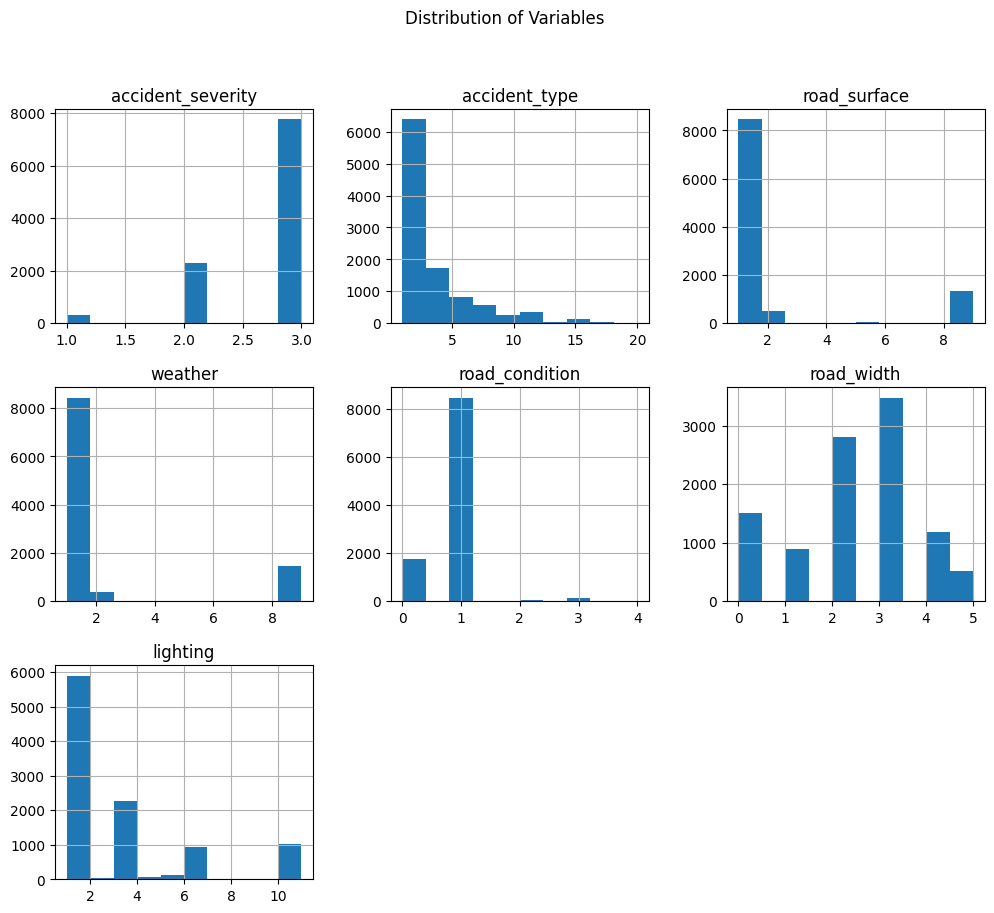

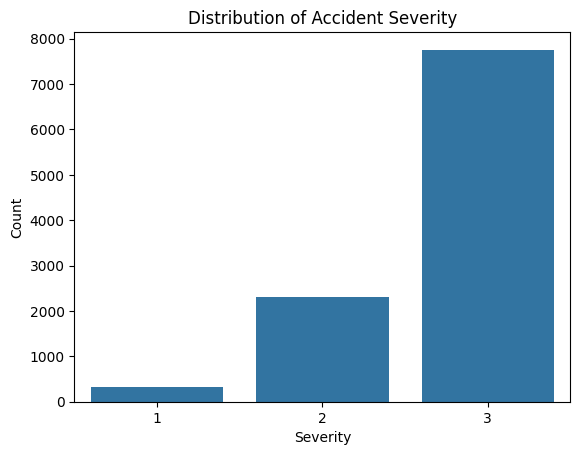

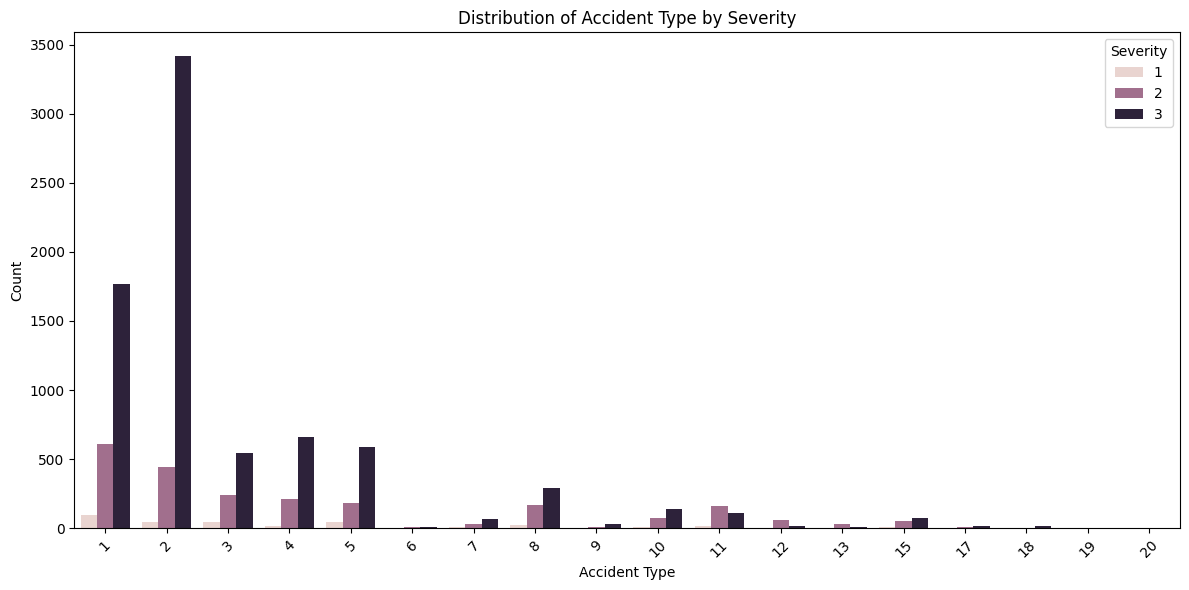

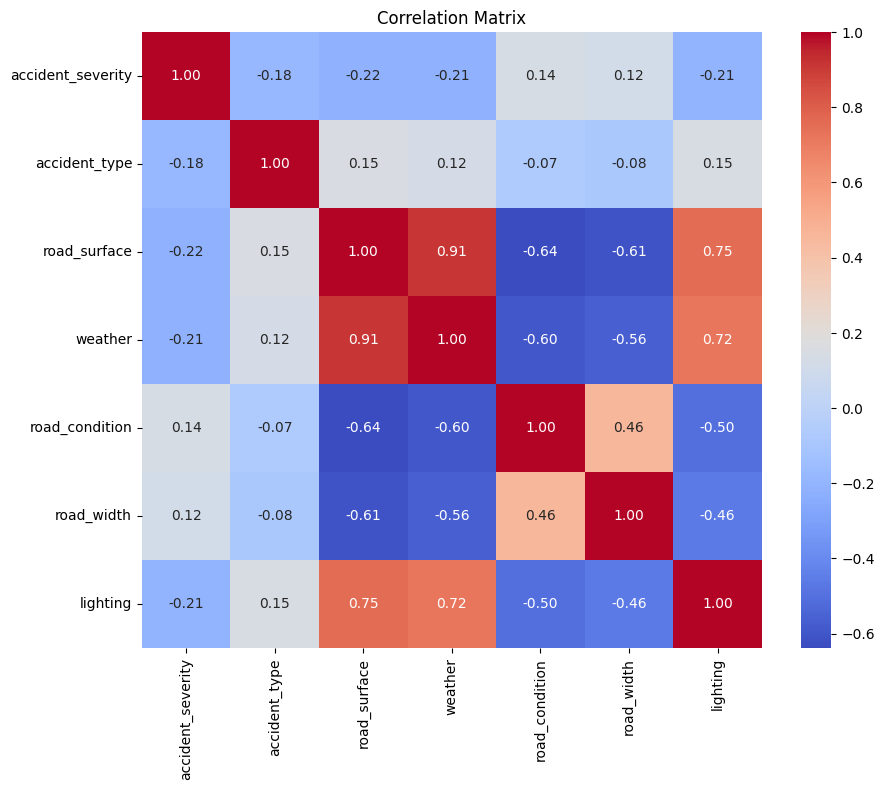

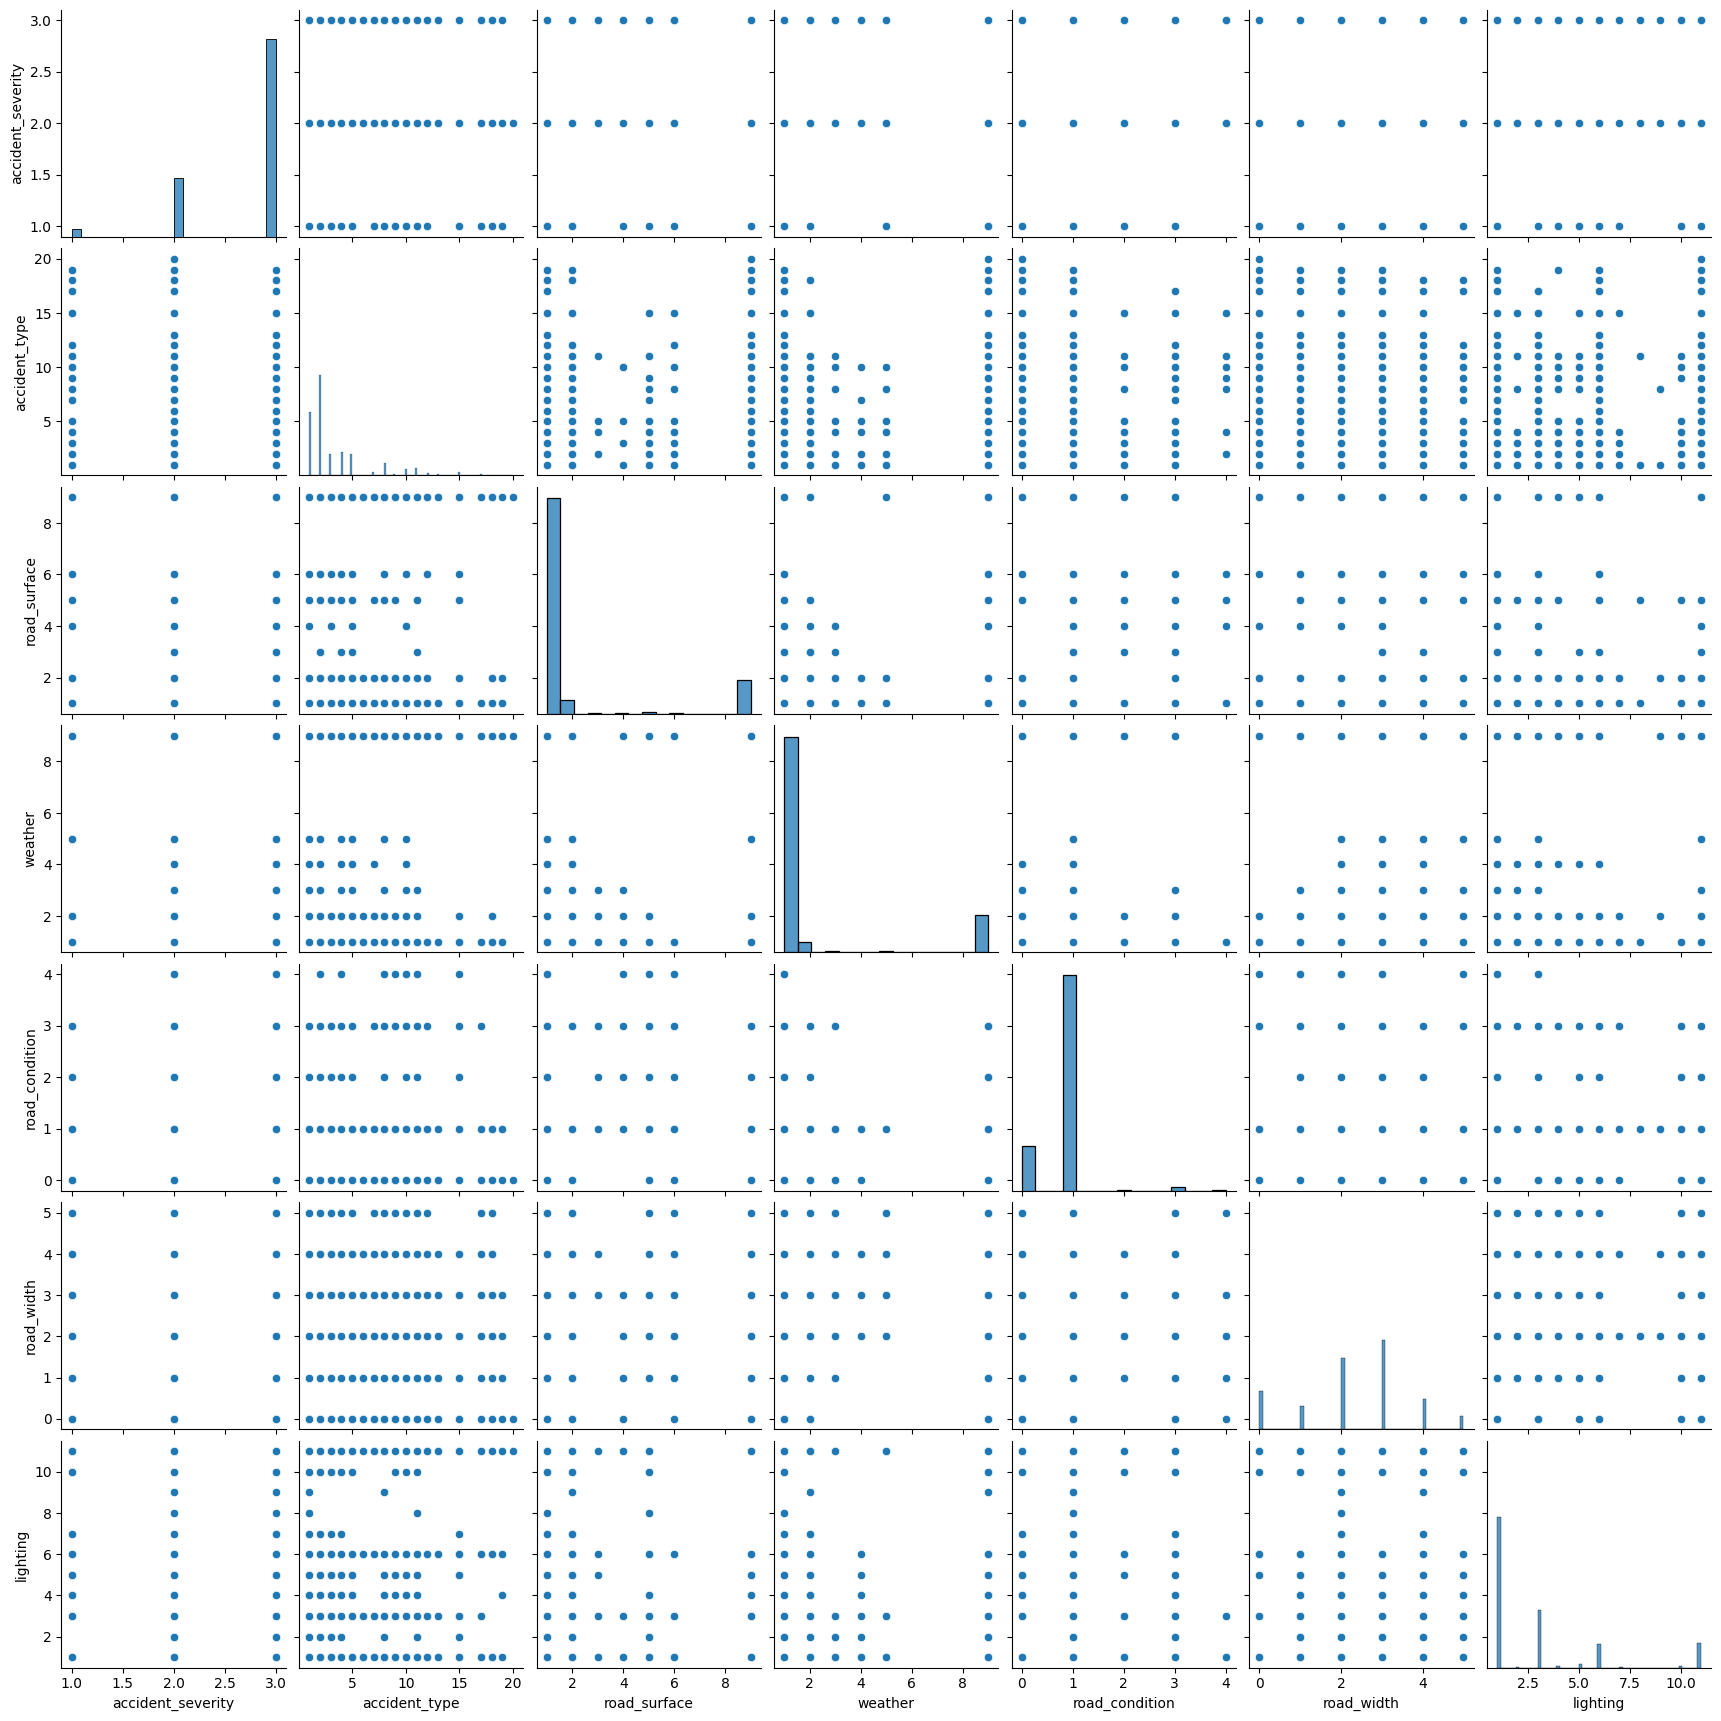

In [21]:
conditions_df.hist(figsize=(12, 10))
plt.suptitle('Distribution of Variables')
plt.show()

sns.countplot(data=conditions_df, x='accident_severity')
plt.title('Distribution of Accident Severity')
plt.xlabel('Severity')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(data=conditions_df, x='accident_type', hue='accident_severity')
plt.title('Distribution of Accident Type by Severity')
plt.xlabel('Accident Type')
plt.ylabel('Count')
plt.legend(title='Severity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

correlation_matrix = conditions_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

sns.pairplot(conditions_df, vars=['accident_severity', 'accident_type', 'road_surface', 'weather', 'road_condition', 'road_width', 'lighting'])
plt.show()

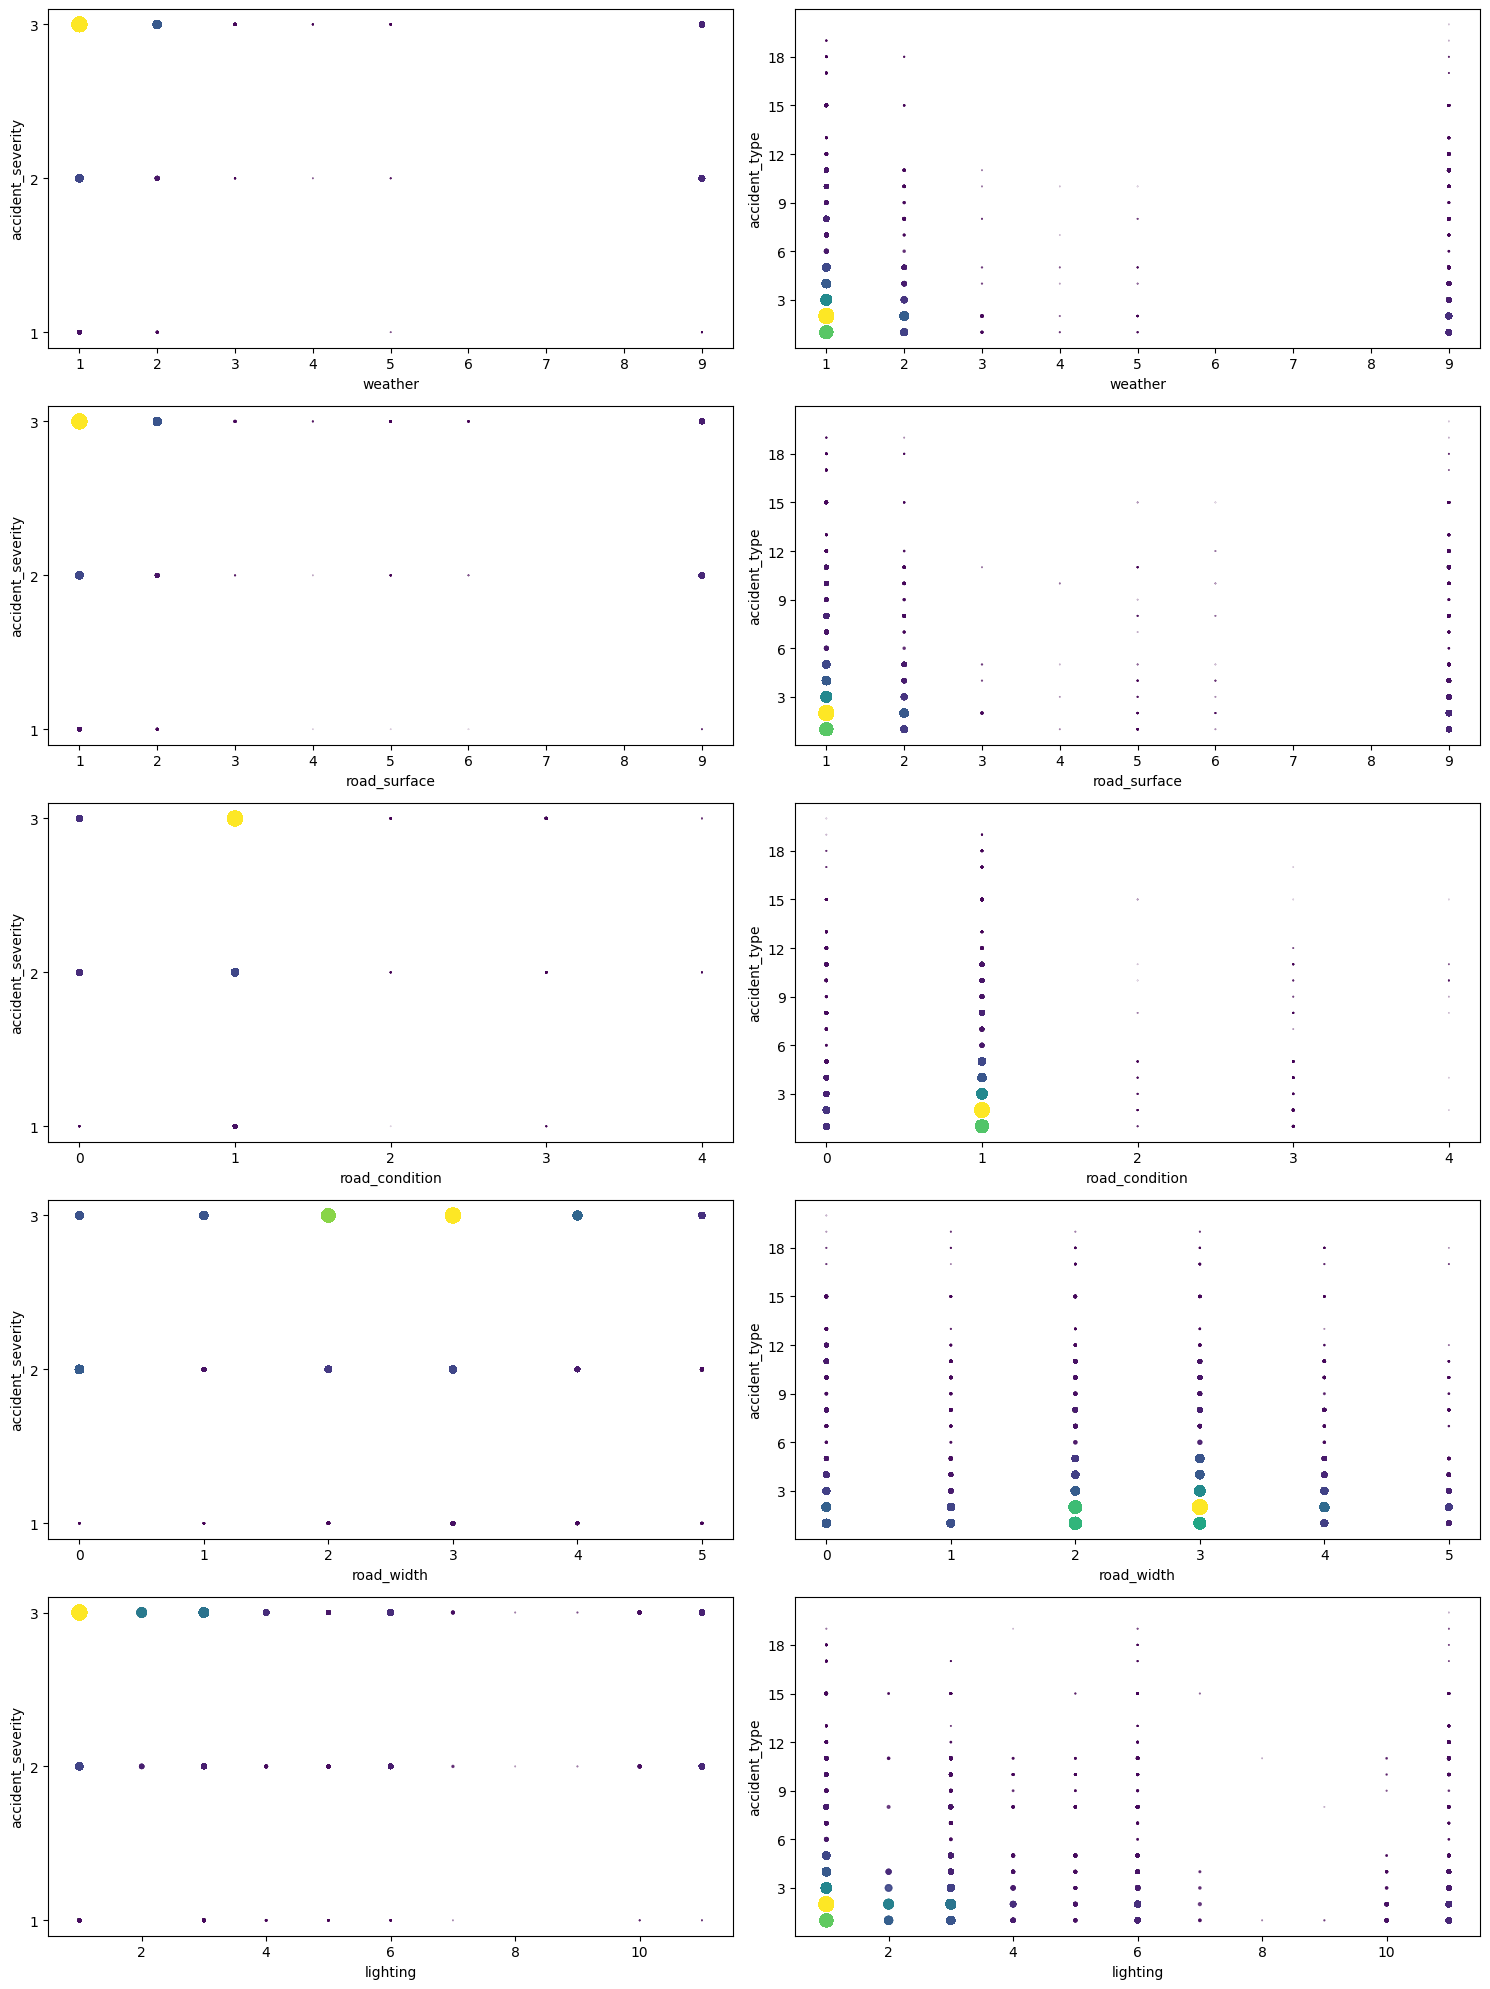

In [22]:
pairs = [('weather', 'accident_severity'),
         ('weather', 'accident_type'),
         ('road_surface', 'accident_severity'),
         ('road_surface', 'accident_type'),
         ('road_condition', 'accident_severity'),
         ('road_condition', 'accident_type'),
         ('road_width', 'accident_severity'),
         ('road_width', 'accident_type'),
         ('lighting', 'accident_severity'),
         ('lighting', 'accident_type')
        ]

fig, axes = plt.subplots(5, 2, figsize=(15, 20))
for i, (x_col, y_col) in enumerate(pairs):
    x = df[x_col].reset_index(drop=True)
    y = df[y_col].reset_index(drop=True)

    k = gaussian_kde(np.vstack([x, y]))
    density = k(np.vstack([x, y]))
    idx = density.argsort()
    x, y, density = x[idx], y[idx], density[idx]
    sizes = 100 * density / max(density)
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    ax.scatter(x, y, c=density, cmap='viridis', s=sizes, alpha=0.7)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)

    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

# Divison data

In [23]:
df_urban_intersection = df[df['road_type'] == 1]
df_urban_not_intersection = df[df['road_type'] == 2]
df_non_urban_intersection  = df[df['road_type'] == 3]
df_non_urban_not_intersection = df[df['road_type'] == 4]

In [24]:
df_urban_intersection = df_urban_intersection.drop(['municipal_crossroad',"road_number1","road_number2",'not_municipal_crossroad'] , axis=1)
df_urban_not_intersection = df_urban_not_intersection.drop(['municipal_crossroad',"road_number1","road_number2",'not_municipal_crossroad'] , axis=1)
df_non_urban_intersection = df_non_urban_intersection.drop(['municipal_crossroad',"road_number1","road_number2",'not_municipal_crossroad'] , axis=1)
df_non_urban_not_intersection = df_non_urban_not_intersection.drop(['municipal_crossroad',"road_number1","road_number2",'not_municipal_crossroad'] , axis=1)

In [25]:
# Remove the rows in all dataframe that have parameter "לא ידוע"
df_urban_intersection = df_urban_intersection[~((df_urban_intersection['road_width'] == 0) &
                                                (df_urban_intersection['road_condition'] == 0) &
                                                (df_urban_intersection['weather'] == 9) &
                                                (df_urban_intersection['road_surface'] == 9))]
df_urban_not_intersection = df_urban_not_intersection[~((df_urban_not_intersection['road_width'] == 0) &
                                                        (df_urban_not_intersection['road_condition'] == 0) &
                                                        (df_urban_not_intersection['weather'] == 9) &
                                                        (df_urban_not_intersection['road_surface'] == 9))]
df_non_urban_intersection = df_non_urban_intersection[~((df_non_urban_intersection['road_width'] == 0) &
                                                        (df_non_urban_intersection['road_condition'] == 0) &
                                                        (df_non_urban_intersection['weather'] == 9) &
                                                        (df_non_urban_intersection['road_surface'] == 9))]
df_non_urban_not_intersection = df_non_urban_not_intersection[~((df_non_urban_not_intersection['road_width'] == 0) &
                                                                (df_non_urban_not_intersection['road_condition'] == 0) &
                                                                (df_non_urban_not_intersection['weather'] == 9) &
                                                                (df_non_urban_not_intersection['road_surface'] == 9))]

In [26]:
df_urban_intersection = df_urban_intersection.reset_index(drop=True)
df_urban_not_intersection = df_urban_not_intersection.reset_index(drop=True)
df_non_urban_intersection = df_non_urban_intersection.reset_index(drop=True)
df_non_urban_not_intersection = df_non_urban_not_intersection.reset_index(drop=True)


In [27]:
print(len(df_urban_intersection))
print(len(df_urban_not_intersection))
print(len(df_non_urban_intersection))
print(len(df_non_urban_not_intersection))

3089
2846
1320
1882


In [28]:
df_urban_intersection.head(5)

accident_number  road_type  accident_severity  accident_type  speed_limit  \
0       2021031094          1                  3              2            1   
1       2022000012          1                  3              4            1   
2       2022000022          1                  3              2            1   
3       2022000048          1                  3              1            1   
4       2022000073          1                  3              5            1   

   road_condition  road_width  road_sign  lighting  weather  road_surface  \
0               1           4          3         3        1             1   
1               1           2          3         6        1             1   
2               1           1          3         1        1             1   
3               1           2          3         1        1             1   
4               1           5          3         1        1             1   

   natural_area         x1         y1  
0           246  32.924485  35.078124  
1           512  32.085713  34.836534  
2           411  32.319786  34.861757  
3           512  32.092350  34.833393  
4           512  32.020157  34.860739

In [29]:
#בדיקה חלוקה לפי איזור טבעי
natural_areas = df['natural_area'].unique()
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue',
          'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen',
          'gray', 'black', 'lightgray']

area_colors = {area: colors[i % len(colors)] for i, area in enumerate(natural_areas)}

map_1 = folium.Map(location=[df_urban_intersection['x1'].mean(), df_urban_intersection['y1'].mean()], zoom_start=10)
for _, row in df_urban_intersection.iterrows():
    folium.Marker(
        location=[row['x1'], row['y1']],
        icon=folium.Icon(color=area_colors[row['natural_area']]),
        tooltip=row['natural_area']
    ).add_to(map_1)
map_1

# algorithm

## K-MEANS

### how many cluestering ?

let's veirfy with elbow Method

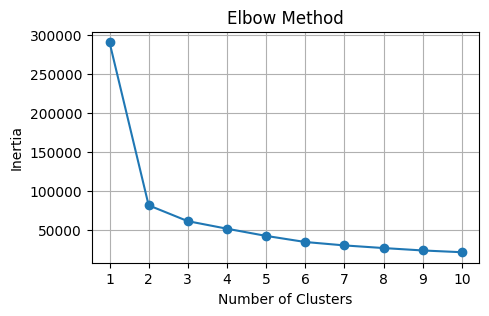

In [ ]:
features = ['road_type', 'road_condition', 'road_width', 'road_sign', 'lighting', 'weather', 'road_surface']
inertia_values = []

for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)  # Définir explicitement le paramètre n_init
    kmeans.fit(df[features])
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(5, 3))
plt.plot(range(1, 11), inertia_values, marker='o', linestyle='-')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

num optimal of cluster = 2

let's veirfy with silhouette score

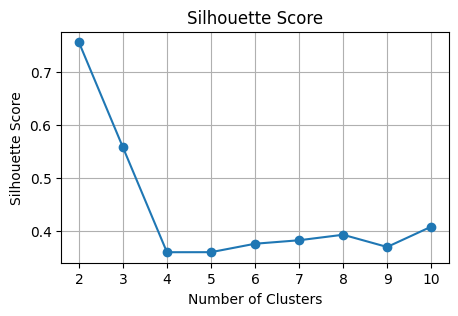

In [ ]:
features = ['road_type', 'road_condition', 'road_width', 'road_sign', 'lighting', 'weather', 'road_surface']
silhouette_scores = []

for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    cluster_labels = kmeans.fit_predict(df[features])
    silhouette_avg = silhouette_score(df[features], cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(5, 3))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()


also with silhouette score num of optimal cluster is 2

### lets try the algorithm

------------------for urban intersection: ------------------

In [ ]:
features = ['road_condition', 'road_width', 'road_sign','weather']

cluster_data = []


for natural_area, group in df_urban_intersection.groupby('natural_area'):
    if len(group) < 2:
        continue

    data = group[features]


    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    kmeans = KMeans(n_clusters=2, n_init=10)
    kmeans.fit(scaled_data)

    predicted_clusters = kmeans.predict(scaled_data)

    avg_severity = group.groupby(predicted_clusters)['accident_severity'].mean().values

    for i, (cluster, center) in enumerate(zip(predicted_clusters, kmeans.cluster_centers_)):
        row = {
            'Natural_Area': natural_area,
            'Cluster': cluster,
            'Accident_Severity_Mean': avg_severity[i],
            **{f'Feature_{j+1}': value for j, value in enumerate(center)}
        }
        cluster_data.append(row)

result_df_urban_intersection = pd.DataFrame(cluster_data)
column_mapping = {
    'Feature_1': 'road_condition',
    'Feature_2': 'road_width',
    'Feature_3': 'road_sign',
    'Feature_4': 'weather',
}
result_df_urban_intersection.rename(columns=column_mapping, inplace=True)
result_df_urban_intersection


Natural_Area  Cluster  Accident_Severity_Mean  road_condition  road_width  \
0            111        0                2.844907       -0.007519   -0.017650   
1            111        1                2.636364        0.295274    0.693179   
2            112        0                2.923077        0.392232   -0.121501   
3            112        0                2.500000       -2.549510    0.789754   
4            211        0                3.000000        0.000000    0.263523   
..           ...      ...                     ...             ...         ...   
71           623        0                3.000000       -6.027714   -0.988779   
72           625        0                3.000000       -0.336574   -0.039375   
73           625        0                2.750000        2.524305    0.295312   
74           777        0                2.947368        0.000000    0.084522   
75           777        0                2.000000        0.000000   -1.605910   

    road_sign   weather  
0   -0.018401 -0.154340  
1    0.722668  6.061372  
2   -0.041117  0.000000  
3    0.267261  0.000000  
4   -0.408248 -0.405052  
..        ...       ...  
71  -0.181071 -0.181489  
72  -0.033333  0.000000  
73   0.250000  0.000000  
74   0.229416  0.012075  
75  -4.358899 -0.229416  

[76 rows x 7 columns]

------------------for urban not intersection------------------

In [ ]:
features = ['road_condition', 'road_width', 'road_sign','weather']

cluster_data = []

for natural_area, group in df_urban_not_intersection.groupby('natural_area'):
    if len(group) < 2:
        continue

    data = group[features]

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    kmeans = KMeans(n_clusters=2, n_init=10)
    kmeans.fit(scaled_data)

    predicted_clusters = kmeans.predict(scaled_data)

    avg_severity = group.groupby(predicted_clusters)['accident_severity'].mean().values

    for i, (cluster, center) in enumerate(zip(predicted_clusters, kmeans.cluster_centers_)):
        row = {
            'Natural_Area': natural_area,
            'Cluster': cluster,
            'Accident_Severity_Mean': avg_severity[i],
            **{f'Feature_{j+1}': value for j, value in enumerate(center)}
        }
        cluster_data.append(row)

result_df_urban_not_intersection = pd.DataFrame(cluster_data)
column_mapping = {
    'Feature_1': 'road_condition',
    'Feature_2': 'road_width',
    'Feature_3': 'road_sign',
    'Feature_4': 'weather'
}
result_df_urban_not_intersection.rename(columns=column_mapping, inplace=True)
result_df_urban_not_intersection

Natural_Area  Cluster  Accident_Severity_Mean  road_condition  road_width  \
0            111        1                2.900000        0.766041    0.987703   
1            111        1                2.726923       -0.029463   -0.037989   
2            112        1                3.000000        0.495188    0.646393   
3            112        1                2.727273       -0.067526   -0.088145   
4            211        1                2.818182        0.000000    0.038189   
..           ...      ...                     ...             ...         ...   
83           625        0                2.500000       -0.328125   -0.426401   
84           626        0                2.500000        0.000000   -0.612372   
85           626        1                2.000000        0.000000    1.224745   
86           777        0                2.500000        0.005493    0.120427   
87           777        0                2.666667       -0.062257   -1.364837   

    road_sign   weather  
0    0.461468  4.969971  
1   -0.017749 -0.191153  
2    0.116248  2.708013  
3   -0.015852 -0.369274  
4    0.301511  0.000000  
..        ...       ...  
83  -0.675077 -0.079950  
84  -0.707107  0.000000  
85   1.414214  0.000000  
86   0.278693  0.000000  
87  -3.158523  0.000000  

[88 rows x 7 columns]

------------------for non urban intersection------------------

In [ ]:
features = ['road_condition', 'road_width', 'road_sign', 'weather']

cluster_data = []

for natural_area, group in df_non_urban_intersection.groupby('natural_area'):
    if len(group) < 2:
        continue

    data = group[features]

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    kmeans = KMeans(n_clusters=2, n_init=10)
    kmeans.fit(scaled_data)

    predicted_clusters = kmeans.predict(scaled_data)

    if len(set(predicted_clusters)) > 1:
        avg_severity = group.groupby(predicted_clusters)['accident_severity'].mean().values
    else:
        avg_severity = [group['accident_severity'].mean()] * len(predicted_clusters)

    for i, (cluster, center) in enumerate(zip(predicted_clusters, kmeans.cluster_centers_)):
        row = {
            'Natural_Area': natural_area,
            'Cluster': cluster,
            'Accident_Severity_Mean': avg_severity[i],
            **{f'Feature_{j+1}': value for j, value in enumerate(center)}
        }
        cluster_data.append(row)

result_df_non_urban_intersection = pd.DataFrame(cluster_data)
column_mapping = {
    'Feature_1': 'road_condition',
    'Feature_2': 'road_width',
    'Feature_3': 'road_sign',
    'Feature_4': 'weather'
}
result_df_non_urban_intersection.rename(columns=column_mapping, inplace=True)
result_df_non_urban_intersection



<ipython-input-113-37559afffd86>:15: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(scaled_data)


Natural_Area  Cluster  Accident_Severity_Mean  road_condition  road_width  \
0            111        0                2.812500       -0.182217    0.026430   
1            111        0                3.000000        2.915476   -0.422885   
2            112        0                2.800000        0.000000    0.073748   
3            112        0                2.000000        0.000000   -1.106223   
4            211        0                2.937500       -0.015625   -0.099474   
..           ...      ...                     ...             ...         ...   
87           623        0                3.000000       -0.089803   -3.593758   
88           626        1                2.666667        0.000000   -0.623610   
89           626        0                3.000000        0.000000    0.935414   
90           777        0                2.768116       -0.165843    0.041940   
91           777        0                3.000000        1.430392   -0.361734   

    road_sign   weather  
0    0.250000  0.015625  
1   -4.000000 -0.250000  
2    0.000000 -0.256181  
3    0.000000  3.842710  
4   -0.135015 -0.248047  
..        ...       ...  
87   2.881755  0.000000  
88  -0.816497  0.000000  
89   1.224745  0.000000  
90  -0.301084  0.014356  
91   2.596849 -0.123824  

[92 rows x 7 columns]

------------------for non urban not intersection------------------

In [ ]:
features = ['road_condition', 'road_width', 'road_sign','weather']

cluster_data = []

for natural_area, group in df_non_urban_not_intersection.groupby('natural_area'):
    if len(group) < 2:
        continue

    data = group[features]

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    kmeans = KMeans(n_clusters=2, n_init=10)
    kmeans.fit(scaled_data)

    predicted_clusters = kmeans.predict(scaled_data)

    avg_severity = group.groupby(predicted_clusters)['accident_severity'].mean().values

    for i, (cluster, center) in enumerate(zip(predicted_clusters, kmeans.cluster_centers_)):
        row = {
            'Natural_Area': natural_area,
            'Cluster': cluster,
            'Accident_Severity_Mean': avg_severity[i],
            **{f'Feature_{j+1}': value for j, value in enumerate(center)}
        }
        cluster_data.append(row)

result_df_non_urban_not_intersection = pd.DataFrame(cluster_data)
column_mapping = {
    'Feature_1': 'road_condition',
    'Feature_2': 'road_width',
    'Feature_3': 'road_sign',
    'Feature_4': 'weather'
}
result_df_non_urban_not_intersection.rename(columns=column_mapping, inplace=True)
result_df_non_urban_not_intersection

Natural_Area  Cluster  Accident_Severity_Mean  road_condition  \
0             111        1                2.555556        0.000000   
1             111        0                2.500000        0.000000   
2             112        0                2.391304        0.208514   
3             112        0                3.000000       -4.795832   
4             211        0                2.687500       -0.030317   
..            ...      ...                     ...             ...   
97            625        1                2.375000       -0.150756   
98            626        0                2.250000        0.000000   
99            626        1                3.000000        0.000000   
100           777        0                2.592000       -0.009281   
101           777        0                2.375000        0.290036   

     road_width  road_sign   weather  
0      0.066757   0.012745 -0.206994  
1     -1.502032  -0.286770  4.657365  
2     -0.063461   0.018265  0.016528  
3      1.459601  -0.420084 -0.380143  
4     -0.104564  -0.353553  0.050111  
..          ...        ...       ...  
97    -0.577350   0.353553 -0.301511  
98     0.196116   0.062500 -0.353553  
99    -1.568929  -0.500000  2.828427  
100    0.004654  -0.010159 -0.171348  
101   -0.145449   0.317461  5.354633  

[102 rows x 7 columns]

### lets verify the mesure quality of algorithm

In [ ]:
results_df_list = [result_df_urban_intersection, result_df_urban_not_intersection,
                   result_df_non_urban_intersection, result_df_non_urban_not_intersection]

metrics_results = []
features = ['road_condition', 'road_width', 'road_sign', 'weather']

for result_df, cluster_name in zip(results_df_list, ['urban_intersection', 'urban_not_intersection',
                                                     'non_urban_intersection', 'non_urban_not_intersection']):
    silhouette_avg = silhouette_score(result_df[features], result_df['Cluster'])

    silhouette_values = silhouette_samples(result_df[features], result_df['Cluster'])
    silhouette_avg_mean = silhouette_values.mean()

    davies_bouldin = davies_bouldin_score(result_df[features], result_df['Cluster'])
    metrics_results.append({
        'Cluster_Name': cluster_name,
        'Silhouette Score': silhouette_avg,
        'Davies-Bouldin Index': davies_bouldin,
        'Mean Silhouette Coefficient': silhouette_avg_mean
    })

metrics_df = pd.DataFrame(metrics_results)
metrics_df

Cluster_Name  Silhouette Score  Davies-Bouldin Index  \
0          urban_intersection         -0.122324             13.450398   
1      urban_not_intersection         -0.153902              5.900054   
2      non_urban_intersection         -0.032850             10.262845   
3  non_urban_not_intersection         -0.062576             11.257331   

   Mean Silhouette Coefficient  
0                    -0.122324  
1                    -0.153902  
2                    -0.032850  
3                    -0.062576

 Silhouette Score : [-1, 1]
* Values close to +1 indicate that the sample is far away from neighboring clusters.
* Values close to 0 indicate that the sample is close to the decision boundary between two neighboring clusters.
* Values close to -1 indicate that the sample is assigned to the wrong cluster.

Davies-Bouldin Index - [0, +∞)
measures the average similarity between each cluster and its most similar cluster, where similarity is defined as the ratio of within-cluster distances to between-cluster distances.
* A lower value indicates better clustering, with values closer to 0 indicating dense and well-separated clusters.
* The Davies-Bouldin Index is minimized when clusters are compact and well-separated.

Mean Silhouette Coefficient -  [-1, 1]
the mean of the Silhouette Coefficients of all samples.
* Higher values indicating denser, well-separated clusters.
* Negative values suggest that samples may have been assigned to the wrong clusters.

## DBSCAN

### lets try the algorithm

In [ ]:
features = ['road_condition', 'road_width', 'road_sign', 'weather']

cluster_data = []

for natural_area, group in df_urban_not_intersection.groupby('natural_area'):
    if len(group) < 2:
        continue

    data = group[features]

    dbscan = DBSCAN(eps=0.05, min_samples=5)
    predicted_clusters = dbscan.fit_predict(data)

    core_points_mask = predicted_clusters != -1
    core_points_data = data[core_points_mask]

    avg_severity = group[core_points_mask].groupby(predicted_clusters[core_points_mask])['accident_severity'].mean().values

    for i, (cluster, avg_severity) in enumerate(zip(predicted_clusters[core_points_mask], avg_severity)):
        row = {
            'Natural_Area': natural_area,
            'Cluster': cluster,
            'Accident_Severity_Mean': avg_severity,
            **{f'Feature_{j+1}': value for j, value in enumerate(core_points_data.iloc[i])}
        }
        cluster_data.append(row)

result_df_urban_not_intersection_dbscan = pd.DataFrame(cluster_data)
column_mapping = {
    'Feature_1': 'road_condition',
    'Feature_2': 'road_width',
    'Feature_3': 'road_sign',
    'Feature_4': 'weather'
}
result_df_urban_not_intersection_dbscan.rename(columns=column_mapping, inplace=True)
result_df_urban_not_intersection_dbscan


Natural_Area  Cluster  Accident_Severity_Mean  road_condition  \
0             111        0                2.715909               1   
1             111        0                2.687500               1   
2             111        1                2.696429               1   
3             111        2                3.000000               1   
4             111        0                2.666667               1   
..            ...      ...                     ...             ...   
100           614        1                2.833333               1   
101           623        0                2.222222               1   
102           623        1                2.571429               1   
103           777        0                2.500000               1   
104           777        1                2.571429               1   

     road_width  road_sign  weather  
0             2          3        1  
1             2          3        1  
2             1          3        1  
3             3          3        1  
4             2          3        1  
..          ...        ...      ...  
100           2          3        1  
101           3          3        1  
102           2          3        1  
103           3          3        1  
104           2          3        1  

[105 rows x 7 columns]

In [ ]:
features = ['road_condition', 'road_width', 'road_sign', 'weather']

cluster_data = []

for natural_area, group in df_urban_intersection.groupby('natural_area'):
    if len(group) < 2:
        continue

    data = group[features]
    dbscan = DBSCAN(eps=0.05, min_samples=5)
    predicted_clusters = dbscan.fit_predict(data)

    core_points_mask = predicted_clusters != -1
    core_points_data = data[core_points_mask]

    avg_severity = group[core_points_mask].groupby(predicted_clusters[core_points_mask])['accident_severity'].mean().values

    for i, (cluster, avg_severity) in enumerate(zip(predicted_clusters[core_points_mask], avg_severity)):
        row = {
            'Natural_Area': natural_area,
            'Cluster': cluster,
            'Accident_Severity_Mean': avg_severity,
            **{f'Feature_{j+1}': value for j, value in enumerate(core_points_data.iloc[i])}
        }
        cluster_data.append(row)

result_df_urban_intersection_dbscan = pd.DataFrame(cluster_data)
column_mapping = {
    'Feature_1': 'road_condition',
    'Feature_2': 'road_width',
    'Feature_3': 'road_sign',
    'Feature_4': 'weather'
}
result_df_urban_intersection_dbscan.rename(columns=column_mapping, inplace=True)
result_df_urban_intersection_dbscan


Natural_Area  Cluster  Accident_Severity_Mean  road_condition  \
0             111        0                2.848485               1   
1             111        1                2.821705               1   
2             111        0                2.937500               1   
3             111        2                2.846154               0   
4             111        3                3.000000               1   
..            ...      ...                     ...             ...   
96            623        0                3.000000               1   
97            623        0                2.666667               1   
98            625        0                3.000000               1   
99            777        0                3.000000               1   
100           777        1                3.000000               1   

     road_width  road_sign  weather  
0             2          3        1  
1             3          3        1  
2             2          3        1  
3             3          3        1  
4             4          3        1  
..          ...        ...      ...  
96            3          3        1  
97            3          3        1  
98            2          3        1  
99            3          3        1  
100           2          3        1  

[101 rows x 7 columns]

In [ ]:
features = ['road_condition', 'road_width', 'road_sign', 'weather']

cluster_data = []

for natural_area, group in df_non_urban_intersection.groupby('natural_area'):

    if len(group) < 2:
        continue

    data = group[features]

    dbscan = DBSCAN(eps=0.05, min_samples=5)
    predicted_clusters = dbscan.fit_predict(data)

    core_points_mask = predicted_clusters != -1
    core_points_data = data[core_points_mask]

    avg_severity = group[core_points_mask].groupby(predicted_clusters[core_points_mask])['accident_severity'].mean().values

    for i, (cluster, avg_severity) in enumerate(zip(predicted_clusters[core_points_mask], avg_severity)):
        row = {
            'Natural_Area': natural_area,
            'Cluster': cluster,
            'Accident_Severity_Mean': avg_severity,
            **{f'Feature_{j+1}': value for j, value in enumerate(core_points_data.iloc[i])}
        }
        cluster_data.append(row)

result_df_non_urban_intersection_dbscan = pd.DataFrame(cluster_data)
column_mapping = {
    'Feature_1': 'road_condition',
    'Feature_2': 'road_width',
    'Feature_3': 'road_sign',
    'Feature_4': 'weather'
}
result_df_non_urban_intersection_dbscan.rename(columns=column_mapping, inplace=True)
result_df_non_urban_intersection_dbscan



Natural_Area  Cluster  Accident_Severity_Mean  road_condition  road_width  \
0            111        0                2.833333               1           3   
1            213        0                2.888889               1           3   
2            221        0                2.571429               1           3   
3            222        0                2.833333               1           3   
4            234        0                2.846154               1           3   
..           ...      ...                     ...             ...         ...   
71           622        0                2.833333               1           3   
72           623        0                2.846154               1           3   
73           777        0                2.875000               1           3   
74           777        1                2.800000               1           2   
75           777        0                2.600000               1           3   

    road_sign  weather  
0           3        1  
1           3        1  
2           3        1  
3           3        1  
4           3        1  
..        ...      ...  
71          3        1  
72          3        1  
73          3        1  
74          3        1  
75          3        1  

[76 rows x 7 columns]

In [ ]:
features = ['road_condition', 'road_width', 'road_sign', 'weather']

cluster_data = []

for natural_area, group in df_non_urban_not_intersection.groupby('natural_area'):
    if len(group) < 2:
        continue

    data = group[features]
    dbscan = DBSCAN(eps=0.05, min_samples=5)
    predicted_clusters = dbscan.fit_predict(data)

    core_points_mask = predicted_clusters != -1
    core_points_data = data[core_points_mask]

    avg_severity = group[core_points_mask].groupby(predicted_clusters[core_points_mask])['accident_severity'].mean().values

    for i, (cluster, avg_severity) in enumerate(zip(predicted_clusters[core_points_mask], avg_severity)):
        row = {
            'Natural_Area': natural_area,
            'Cluster': cluster,
            'Accident_Severity_Mean': avg_severity,
            **{f'Feature_{j+1}': value for j, value in enumerate(core_points_data.iloc[i])}
        }
        cluster_data.append(row)

result_df_non_urban_not_intersection_dbscan = pd.DataFrame(cluster_data)
column_mapping = {
    'Feature_1': 'road_condition',
    'Feature_2': 'road_width',
    'Feature_3': 'road_sign',
    'Feature_4': 'weather'
}
result_df_non_urban_not_intersection_dbscan.rename(columns=column_mapping, inplace=True)
result_df_non_urban_not_intersection_dbscan

Natural_Area  Cluster  Accident_Severity_Mean  road_condition  road_width  \
0            111        0                2.333333               1           4   
1            111        1                2.300000               1           3   
2            111        2                2.769231               1           2   
3            112        0                1.833333               1           3   
4            211        0                2.800000               1           3   
..           ...      ...                     ...             ...         ...   
90           777        1                2.532258               1           3   
91           777        2                2.250000               0           3   
92           777        3                3.000000               1           2   
93           777        1                2.676471               1           3   
94           777        1                2.727273               1           3   

    road_sign  weather  
0           3        1  
1           3        1  
2           3        1  
3           3        1  
4           3        1  
..        ...      ...  
90          3        1  
91          3        1  
92          3        2  
93          3        1  
94          3        1  

[95 rows x 7 columns]

### lets verify the mesure quality of algorithm

In [ ]:
results_df_list = [result_df_urban_intersection_dbscan, result_df_urban_not_intersection_dbscan,
                   result_df_non_urban_intersection_dbscan, result_df_non_urban_not_intersection_dbscan]

metrics_results = []

features = ['road_condition', 'road_width', 'road_sign', 'weather']

for result_df, cluster_name in zip(results_df_list, ['urban_intersection_dbscan', 'urban_not_intersection_dbscan',
                                                     'non_urban_intersection_dbscan', 'non_urban_not_intersection_dbscan']):
    silhouette_avg = silhouette_score(result_df[features], result_df['Cluster'])


    silhouette_values = silhouette_samples(result_df[features], result_df['Cluster'])
    silhouette_avg_mean = silhouette_values.mean()

    davies_bouldin = davies_bouldin_score(result_df[features], result_df['Cluster'])

    metrics_results.append({
        'Cluster_Name': cluster_name,
        'Silhouette Score': silhouette_avg,
        'Davies-Bouldin Index': davies_bouldin,
        'Mean Silhouette Coefficient': silhouette_avg_mean
    })

metrics_df_dbscan = pd.DataFrame(metrics_results)
metrics_df_dbscan

Cluster_Name  Silhouette Score  Davies-Bouldin Index  \
0          urban_intersection_dbscan         -0.276079              8.859754   
1      urban_not_intersection_dbscan         -0.095839              6.022785   
2      non_urban_intersection_dbscan         -0.013173             39.018879   
3  non_urban_not_intersection_dbscan          0.034356              5.569203   

   Mean Silhouette Coefficient  
0                    -0.276079  
1                    -0.095839  
2                    -0.013173  
3                     0.034356

## Agglomerative Hierarchical Clustering

### how many cluestering ?

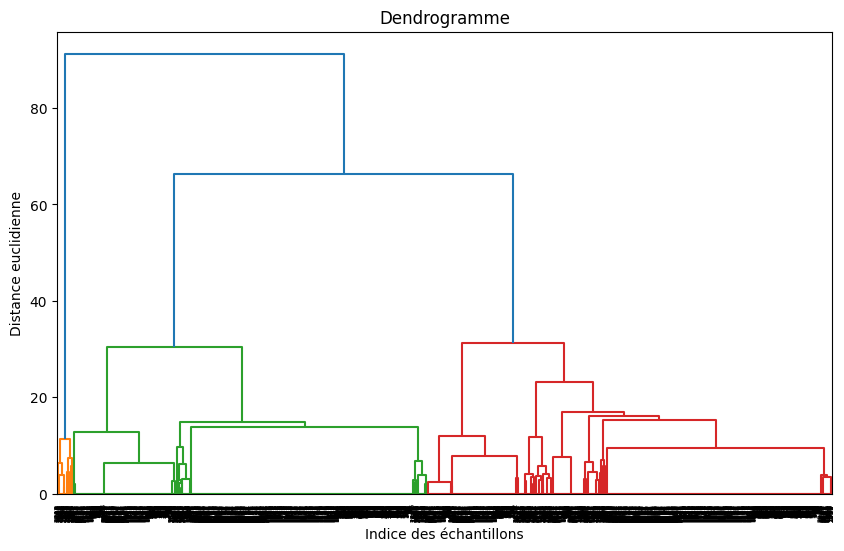

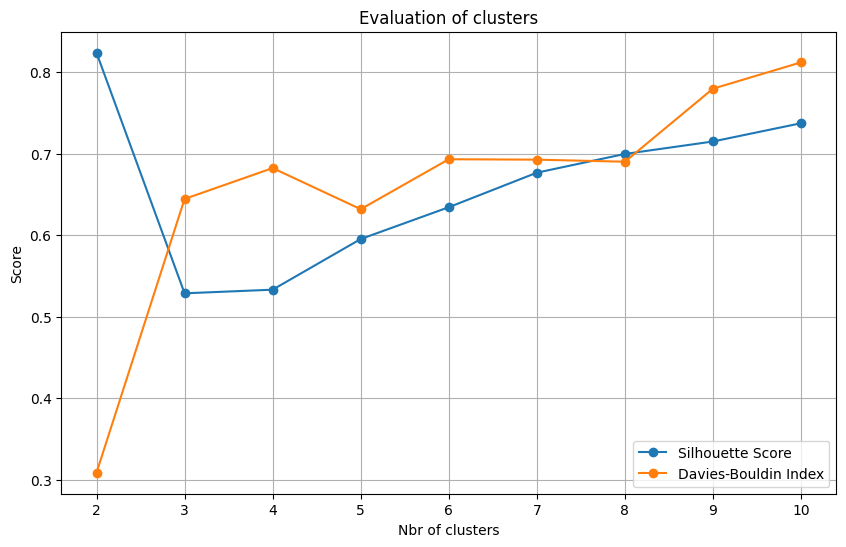

In [30]:
features = ['road_condition', 'road_width', 'road_sign', 'weather']
data = df_urban_intersection[features]

linkage_matrix = linkage(data, method='ward')

plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix)
plt.title('Dendrogramme')
plt.xlabel('Indice des échantillons')
plt.ylabel('Distance euclidienne')
plt.show()

silhouette_scores = []
davies_bouldin_scores = []

for n_clusters in range(2, 11):
    clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(data)
    labels = clustering.labels_
    silhouette_scores.append(silhouette_score(data, labels))
    davies_bouldin_scores.append(davies_bouldin_score(data, labels))

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', label='Silhouette Score')
plt.plot(range(2, 11), davies_bouldin_scores, marker='o', label='Davies-Bouldin Index')
plt.title('Evaluation of clusters')
plt.xlabel('Nbr of clusters')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


explication: the number of cluster need to be the max of silhouette score and the min of davies bouldin index also here this is 2

### lets try the algorithm

In [31]:
features = ['road_condition', 'road_width', 'road_sign', 'weather']
n_clusters = 2
cluster_stats_urban_intersection = pd.DataFrame()
for natural_area, group in df_urban_intersection.groupby('natural_area'):
    if len(group) < 2:
        continue

    data = group[features]

    clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(data)

    group['cluster'] = clustering.labels_

    natural_area_stats = group.groupby('cluster').mean()

    natural_area_stats['Natural_Area'] = natural_area
    cluster_stats_urban_intersection = pd.concat([cluster_stats_urban_intersection, natural_area_stats])
cluster_stats_urban_intersection

accident_number  road_type  accident_severity  accident_type  \
cluster                                                                 
0           2.022051e+09        1.0           2.844186       2.132558   
1           2.022046e+09        1.0           2.692308       1.846154   
0           2.022056e+09        1.0           2.875000       1.125000   
1           2.022054e+09        1.0           2.857143       5.714286   
0           2.022044e+09        1.0           3.000000       2.500000   
...                  ...        ...                ...            ...   
1           2.022040e+09        1.0           2.827586       2.034483   
0           2.022044e+09        1.0           3.000000       2.066667   
1           2.022035e+09        1.0           2.750000       2.500000   
0           2.022049e+09        1.0           2.894737       2.842105   
1           2.022038e+09        1.0           3.000000       1.000000   

         speed_limit  road_condition  road_width  road_sign  lighting  \
cluster                                                                 
0           1.158140        0.895349    2.488372   2.946512  1.886047   
1           2.615385        1.000000    3.153846   3.307692  4.076923   
0           1.000000        1.000000    1.500000   2.750000  2.375000   
1           1.428571        0.714286    3.142857   3.000000  2.714286   
0           1.666667        1.000000    2.833333   3.000000  2.000000   
...              ...             ...         ...        ...       ...   
1           1.206897        0.965517    1.724138   3.137931  1.275862   
0           0.966667        0.900000    2.000000   3.100000  1.666667   
1           0.750000        3.250000    2.250000   3.250000  1.000000   
0           1.052632        1.000000    2.789474   2.947368  1.789474   
1           1.000000        1.000000    2.000000   3.000000  4.000000   

          weather  road_surface  natural_area         x1         y1  \
cluster                                                               
0        1.037209      1.058140         111.0  31.782298  35.212053   
1        8.384615      2.076923         111.0  31.791898  35.202554   
0        1.000000      1.000000         112.0  31.730140  34.990466   
1        1.000000      1.571429         112.0  31.738492  34.984551   
0        1.166667      1.166667         211.0  33.211516  35.570568   
...           ...           ...           ...        ...        ...   
1        1.000000      1.000000         623.0  31.247321  34.793557   
0        1.000000      1.000000         625.0  29.556721  34.944366   
1        1.000000      2.000000         625.0  29.556394  34.938881   
0        1.000000      1.000000         777.0  31.873351  35.262493   
1        9.000000      1.000000         777.0  32.070217  35.264387   

         Natural_Area  
cluster                
0                 111  
1                 111  
0                 112  
1                 112  
0                 211  
...               ...  
1                 623  
0                 625  
1                 625  
0                 777  
1                 777  

[76 rows x 15 columns]

In [32]:
cluster_stats_urban_intersection.drop(columns=['natural_area'], inplace=True)
cluster_stats_urban_intersection.reset_index(inplace=True)

In [33]:
features = ['road_condition', 'road_width', 'road_sign', 'weather']
n_clusters = 2

cluster_stats_urban_not_intersection = pd.DataFrame()

for natural_area, group in df_urban_not_intersection.groupby('natural_area'):
    if len(group) < 2:
        continue

    data = group[features]

    clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(data)

    group['cluster'] = clustering.labels_

    natural_area_stats = group.groupby('cluster').mean()

    natural_area_stats['Natural_Area'] = natural_area
    cluster_stats_urban_not_intersection = pd.concat([cluster_stats_urban_not_intersection, natural_area_stats])
cluster_stats_urban_not_intersection

accident_number  road_type  accident_severity  accident_type  \
cluster                                                                 
0           2.022049e+09        2.0           2.727969       3.191571   
1           2.022064e+09        2.0           2.888889       2.666667   
0           2.022051e+09        2.0           2.727273       3.136364   
1           2.022073e+09        2.0           3.000000       1.333333   
0           2.022043e+09        2.0           2.818182       3.181818   
...                  ...        ...                ...            ...   
1           2.022042e+09        2.0           2.500000       4.000000   
0           2.022034e+09        2.0           2.500000       3.000000   
1           2.022023e+09        2.0           2.000000       2.000000   
0           2.022050e+09        2.0           2.600000       3.350000   
1           2.022055e+09        2.0           2.411765       3.235294   

         speed_limit  road_condition  road_width  road_sign  lighting  \
cluster                                                                 
0           1.249042        0.931034    2.260536   2.957854  1.934866   
1           3.777778        1.333333    3.222222   3.333333  5.555556   
0           1.000000        1.090909    2.090909   2.863636  2.136364   
1           3.333333        1.333333    2.666667   3.000000  7.333333   
0           1.000000        1.000000    2.272727   3.000000  1.363636   
...              ...             ...         ...        ...       ...   
1           1.000000        1.000000    2.500000   3.500000  3.500000   
0           1.000000        1.000000    2.500000   3.000000  1.000000   
1           1.000000        1.000000    4.000000   4.000000  3.000000   
0           1.000000        1.000000    1.800000   2.800000  1.550000   
1           1.117647        1.058824    3.235294   3.000000  2.470588   

          weather  road_surface  natural_area         x1         y1  \
cluster                                                               
0        1.057471      1.172414         111.0  31.784236  35.211637   
1        9.000000      3.888889         111.0  31.784295  35.207287   
0        1.000000      1.000000         112.0  31.735821  34.987497   
1        9.000000      3.666667         112.0  31.745877  34.978197   
0        1.000000      1.090909         211.0  33.217835  35.582781   
...           ...           ...           ...        ...        ...   
1        9.000000      9.000000         625.0  29.575028  34.961444   
0        1.000000      1.000000         626.0  31.025855  34.983322   
1        1.000000      1.000000         626.0  31.065668  35.034651   
0        1.000000      1.200000         777.0  31.914301  35.178141   
1        1.000000      1.000000         777.0  31.859543  35.157108   

         Natural_Area  
cluster                
0                 111  
1                 111  
0                 112  
1                 112  
0                 211  
...               ...  
1                 625  
0                 626  
1                 626  
0                 777  
1                 777  

[88 rows x 15 columns]

In [34]:
cluster_stats_urban_not_intersection.drop(columns=['natural_area'], inplace=True)
cluster_stats_urban_not_intersection.reset_index(inplace=True)

In [35]:
features = ['road_condition', 'road_width', 'road_sign', 'weather']

n_clusters = 2
cluster_stats_non_urban_intersection = pd.DataFrame()

for natural_area, group in df_non_urban_intersection.groupby('natural_area'):
    if len(group) < 2:
        continue

    data = group[features]

    clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(data)

    group['cluster'] = clustering.labels_

    natural_area_stats = group.groupby('cluster').mean()

    natural_area_stats['Natural_Area'] = natural_area
    cluster_stats_non_urban_intersection = pd.concat([cluster_stats_non_urban_intersection, natural_area_stats])

cluster_stats_non_urban_intersection

accident_number  road_type  accident_severity  accident_type  \
cluster                                                                 
0           2.022055e+09        3.0           2.875000       4.000000   
1           2.022100e+09        3.0           2.000000       1.000000   
0           2.022048e+09        3.0           2.800000       2.133333   
1           2.022016e+09        3.0           2.000000       2.000000   
0           2.022048e+09        3.0           2.937500       2.875000   
...                  ...        ...                ...            ...   
1           2.022079e+09        3.0           3.000000       2.000000   
0           2.022070e+09        3.0           2.666667       3.000000   
1           2.022051e+09        3.0           3.000000       5.000000   
0           2.022048e+09        3.0           2.786667       2.466667   
1           2.022047e+09        3.0           3.000000       2.000000   

         speed_limit  road_condition  road_width  road_sign  lighting  \
cluster                                                                 
0           1.562500        1.000000    2.312500   2.875000  2.250000   
1           4.000000        1.000000    4.000000   3.000000  3.000000   
0           3.800000        1.000000    3.266667   3.000000  2.133333   
1           5.000000        1.000000    2.000000   3.000000  3.000000   
0           3.687500        0.937500    3.187500   3.125000  1.500000   
...              ...             ...         ...        ...       ...   
1           5.000000        1.000000    0.000000   5.000000  1.000000   
0           4.333333        1.000000    2.333333   3.000000  4.333333   
1           4.000000        1.000000    3.500000   4.000000  1.000000   
0           3.813333        0.986667    3.186667   3.106667  1.893333   
1           3.500000        0.500000    2.500000   3.000000  3.500000   

          weather  road_surface  natural_area         x1         y1  \
cluster                                                               
0        1.000000      1.000000         111.0  31.794481  35.204575   
1        9.000000      2.000000         111.0  31.807585  35.203862   
0        1.066667      1.066667         112.0  31.757947  34.961256   
1        9.000000      2.000000         112.0  31.794610  34.830913   
0        1.062500      1.062500         211.0  33.159851  35.608055   
...           ...           ...           ...        ...        ...   
1        1.000000      1.000000         623.0  31.191396  34.805521   
0        1.000000      1.000000         626.0  31.041392  34.813372   
1        1.000000      1.000000         626.0  30.935639  34.777694   
0        1.080000      1.133333         777.0  31.957872  35.180885   
1        9.000000      3.500000         777.0  31.973677  35.211177   

         Natural_Area  
cluster                
0                 111  
1                 111  
0                 112  
1                 112  
0                 211  
...               ...  
1                 623  
0                 626  
1                 626  
0                 777  
1                 777  

[92 rows x 15 columns]

In [36]:
cluster_stats_non_urban_intersection.drop(columns=['natural_area'], inplace=True)
cluster_stats_non_urban_intersection.reset_index(inplace=True)

In [37]:
features = ['road_condition', 'road_width', 'road_sign', 'weather']

n_clusters = 2

cluster_stats_non_urban_not_intersection = pd.DataFrame()
for natural_area, group in df_non_urban_not_intersection.groupby('natural_area'):
    if len(group) < 2:
        continue

    data = group[features]
    clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(data)
    group['cluster'] = clustering.labels_
    natural_area_stats = group.groupby('cluster').mean()

    natural_area_stats['Natural_Area'] = natural_area
    cluster_stats_non_urban_not_intersection = pd.concat([cluster_stats_non_urban_not_intersection, natural_area_stats])

cluster_stats_non_urban_not_intersection

accident_number  road_type  accident_severity  accident_type  \
cluster                                                                 
0           2.022056e+09        4.0           2.555556       4.488889   
1           2.022036e+09        4.0           2.500000       3.500000   
0           2.022040e+09        4.0           2.454545       4.227273   
1           2.022060e+09        4.0           2.000000       5.000000   
0           2.022035e+09        4.0           2.562500       3.437500   
...                  ...        ...                ...            ...   
1           2.022082e+09        4.0           3.000000      10.000000   
0           2.022068e+09        4.0           2.250000       5.875000   
1           2.022018e+09        4.0           3.000000       5.000000   
0           2.022049e+09        4.0           2.589641       4.167331   
1           2.022047e+09        4.0           2.428571       6.285714   

         speed_limit  road_condition  road_width  road_sign  lighting  \
cluster                                                                 
0           3.288889        1.000000    2.933333   3.111111  2.311111   
1           2.500000        1.000000    1.500000   3.000000  3.000000   
0           4.000000        0.954545    2.818182   3.272727  2.545455   
1           4.000000        1.000000    3.000000   3.000000  3.500000   
0           4.062500        0.937500    3.000000   3.125000  1.562500   
...              ...             ...         ...        ...       ...   
1           5.000000        1.000000    3.000000   3.000000  1.000000   
0           4.375000        1.000000    3.000000   3.375000  2.875000   
1           5.000000        1.000000    2.000000   3.000000  1.000000   
0           3.733068        1.000000    2.976096   2.996016  1.940239   
1           4.000000        1.142857    2.857143   3.142857  2.714286   

          weather  road_surface  natural_area         x1         y1  \
cluster                                                               
0        1.111111      1.288889         111.0  31.773910  35.130910   
1        9.000000      1.000000         111.0  31.716844  35.072829   
0        1.181818      1.181818         112.0  31.762348  34.967656   
1        9.000000      1.000000         112.0  31.700836  34.961336   
0        1.125000      1.125000         211.0  33.158877  35.598575   
...           ...           ...           ...        ...        ...   
1        4.000000      1.000000         625.0  29.845361  35.027503   
0        1.000000      1.000000         626.0  31.007028  34.900132   
1        9.000000      1.000000         626.0  30.791849  34.767939   
0        1.123506      1.143426         777.0  31.956321  35.189318   
1        9.000000      2.714286         777.0  32.064840  35.151717   

         Natural_Area  
cluster                
0                 111  
1                 111  
0                 112  
1                 112  
0                 211  
...               ...  
1                 625  
0                 626  
1                 626  
0                 777  
1                 777  

[102 rows x 15 columns]

In [38]:
cluster_stats_non_urban_not_intersection.drop(columns=['natural_area'], inplace=True)
cluster_stats_non_urban_not_intersection.reset_index(inplace=True)

### lets verify the mesure quality of algorithm

In [39]:
features = ['road_condition', 'road_width', 'road_sign', 'weather']
n_clusters = 2
results = []

for df_name, df in zip(['df_urban_intersection', 'df_urban_not_intersection', 'df_non_urban_intersection', 'df_non_urban_not_intersection'], [df_urban_intersection, df_urban_not_intersection, df_non_urban_intersection, df_non_urban_not_intersection]):
    all_data = df[features]

    clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(all_data)
    silhouette_avg = silhouette_score(all_data, clustering.labels_)
    davies_bouldin = davies_bouldin_score(all_data, clustering.labels_)
    calinski_harabasz = calinski_harabasz_score(all_data, clustering.labels_)
    results.append({
        'Dataframe': df_name,
        'Silhouette Score': silhouette_avg,
        'Davies-Bouldin Index': davies_bouldin,
        'Calinski-Harabasz Index': calinski_harabasz
    })

results_df = pd.DataFrame(results)
results_df

Dataframe  Silhouette Score  Davies-Bouldin Index  \
0          df_urban_intersection          0.823827              0.308764   
1      df_urban_not_intersection          0.821026              0.305629   
2      df_non_urban_intersection          0.804293              0.419100   
3  df_non_urban_not_intersection          0.831820              0.237926   

   Calinski-Harabasz Index  
0              2633.441568  
1              2968.672497  
2              1370.363486  
3              2380.986275

# Results Analysis

In [40]:
def analyze_severity(data, cluster, area, features=['road_condition', 'road_width', 'road_sign', 'weather', 'accident_severity']):
    # Filter dataframe for the specific cluster and area
    filtered_df = data[(data['cluster'] == cluster) & (data['Natural_Area'] == area)]

    # Calculate mean values for each feature
    mean_values = filtered_df[features].mean()

    return mean_values

# Define a function to compare severity across clusters and areas
def compare_clusters_and_areas(data, df_name, area):
    print(f"Comparison for {df_name} in Area {area}:\n")

    # Iterate over each cluster
    for cluster in data['cluster'].unique():
        print(f"Cluster: {cluster}")
        severity_stats = analyze_severity(data, cluster, area)
        print(severity_stats)
        print("\n")

# Define dataframes
dataframes = {
    'Urban Intersection': cluster_stats_urban_intersection,
    'Urban not Intersection': cluster_stats_urban_not_intersection,
    'Non-Urban Intersection': cluster_stats_non_urban_intersection,
    'Non-Urban not Intersection': cluster_stats_non_urban_not_intersection
}

# Define areas
areas = [112]

# Iterate over dataframes and areas
for df_name, dataframe in dataframes.items():
    for area in areas:
        compare_clusters_and_areas(dataframe, df_name, area)

Comparison for Urban Intersection in Area 112:

Cluster: 0
road_condition       1.000
road_width           1.500
road_sign            2.750
weather              1.000
accident_severity    2.875
dtype: float64


Cluster: 1
road_condition       0.714286
road_width           3.142857
road_sign            3.000000
weather              1.000000
accident_severity    2.857143
dtype: float64


Comparison for Urban not Intersection in Area 112:

Cluster: 0
road_condition       1.090909
road_width           2.090909
road_sign            2.863636
weather              1.000000
accident_severity    2.727273
dtype: float64


Cluster: 1
road_condition       1.333333
road_width           2.666667
road_sign            3.000000
weather              9.000000
accident_severity    3.000000
dtype: float64


Comparison for Non-Urban Intersection in Area 112:

Cluster: 0
road_condition       1.000000
road_width           3.266667
road_sign            3.000000
weather              1.066667
accident_severity   

## MAP result - for natural area 112

### df_urban_intersection

In [41]:
features = ['road_condition', 'road_width', 'road_sign', 'weather']
n_clusters = 2
df_urban_intersection_511 = df_urban_intersection[df_urban_intersection['natural_area'] == 112]
clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(df_urban_intersection_511[features])
df_urban_intersection_511['cluster'] = clustering.labels_
map_urban_intersection_511 = folium.Map(location=[df_urban_intersection_511['x1'].mean(), df_urban_intersection_511['y1'].mean()], zoom_start=10)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue',
          'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen',
          'gray', 'black', 'lightgray']

for _, row in df_urban_intersection_511.iterrows():
    weather_value = row['weather']
    road_condition_value = row['road_condition']
    road_sign_value = row['road_sign']

    tooltip_text = f"Cluster: {int(row['cluster'])}, Weather: {weather_value}, Road Condition: {road_condition_value}, Road Sign: {road_sign_value}"

    folium.Marker(
        location=[row['x1'], row['y1']],
        draggable=False,
        tooltip=tooltip_text,
        icon=folium.Icon(color=colors[int(row['cluster']) % len(colors)])
    ).add_to(map_urban_intersection_511)
map_urban_intersection_511

<ipython-input-41-ea1498aab385>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_urban_intersection_511['cluster'] = clustering.labels_


### df_urban_not_intersection

In [42]:
features = ['road_condition', 'road_width', 'road_sign', 'weather']
n_clusters = 2

df_urban_not_intersection_112 = df_urban_not_intersection[df_urban_not_intersection['natural_area'] == 112]

clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(df_urban_not_intersection_112[features])
df_urban_not_intersection_112['cluster'] = clustering.labels_

map_urban_not_intersection_112 = folium.Map(location=[df_urban_not_intersection_112['x1'].mean(), df_urban_not_intersection_112['y1'].mean()], zoom_start=10)

colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue',
          'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen',
          'gray', 'black', 'lightgray']

for _, row in df_urban_not_intersection_112.iterrows():
    weather_value = row['weather']
    road_condition_value = row['road_condition']
    road_sign_value = row['road_sign']

    tooltip_text = f"Cluster: {int(row['cluster'])}, Weather: {weather_value}, Road Condition: {road_condition_value}, Road Sign: {road_sign_value}"

    folium.Marker(
        location=[row['x1'], row['y1']],
        draggable=False,
        tooltip=tooltip_text,
        icon=folium.Icon(color=colors[int(row['cluster']) % len(colors)])
    ).add_to(map_urban_not_intersection_112)

map_urban_not_intersection_112


<ipython-input-42-ee53ccc227b0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_urban_not_intersection_112['cluster'] = clustering.labels_


### df_non_urban_intersection

In [43]:
features = ['road_condition', 'road_width', 'road_sign', 'weather']
n_clusters = 2

df_non_urban_intersection_112 = df_non_urban_intersection[df_non_urban_intersection['natural_area'] == 112]

clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(df_non_urban_intersection_112[features])
df_non_urban_intersection_112['cluster'] = clustering.labels_

map_non_urban_intersection_112 = folium.Map(location=[df_non_urban_intersection_112['x1'].mean(), df_non_urban_intersection_112['y1'].mean()], zoom_start=10)

colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue',
          'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen',
          'gray', 'black', 'lightgray']

for _, row in df_non_urban_intersection_112.iterrows():
    weather_value = row['weather']
    road_condition_value = row['road_condition']
    road_sign_value = row['road_sign']

    tooltip_text = f"Cluster: {int(row['cluster'])}, Weather: {weather_value}, Road Condition: {road_condition_value}, Road Sign: {road_sign_value}"

    folium.Marker(
        location=[row['x1'], row['y1']],
        draggable=False,
        tooltip=tooltip_text,
        icon=folium.Icon(color=colors[int(row['cluster']) % len(colors)])
    ).add_to(map_non_urban_intersection_112)

map_non_urban_intersection_112


<ipython-input-43-f76d49437f6f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_urban_intersection_112['cluster'] = clustering.labels_


### df_non_urban_not_intersection

In [44]:
features = ['road_condition', 'road_width', 'road_sign', 'weather']
n_clusters = 2

df_non_urban_not_intersection_112 = df_non_urban_not_intersection[df_non_urban_not_intersection['natural_area'] == 112]

clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(df_non_urban_not_intersection_112[features])
df_non_urban_not_intersection_112['cluster'] = clustering.labels_

map_non_urban_not_intersection_112 = folium.Map(location=[df_non_urban_not_intersection_112['x1'].mean(), df_non_urban_not_intersection_112['y1'].mean()], zoom_start=10)

colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue',
          'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen',
          'gray', 'black', 'lightgray']

for _, row in df_non_urban_not_intersection_112.iterrows():
    weather_value = row['weather']
    road_condition_value = row['road_condition']
    road_sign_value = row['road_sign']

    tooltip_text = f"Cluster: {int(row['cluster'])}, Weather: {weather_value}, Road Condition: {road_condition_value}, Road Sign: {road_sign_value}"

    folium.Marker(
        location=[row['x1'], row['y1']],
        draggable=False,
        tooltip=tooltip_text,
        icon=folium.Icon(color=colors[int(row['cluster']) % len(colors)])
    ).add_to(map_non_urban_not_intersection_112)

map_non_urban_not_intersection_112


<ipython-input-44-ff2861ffc5db>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_urban_not_intersection_112['cluster'] = clustering.labels_


## Analyzed the distribution of feature values within each cluster type across different natural areas (Top 4 natural areas with the highest number of accidents) and different accident type

In [45]:
top_4_urban_intersection = df_urban_intersection['natural_area'].value_counts().head(4)
top_4_urban_not_intersection = df_urban_not_intersection['natural_area'].value_counts().head(4)
top_4_non_urban_intersection = df_non_urban_intersection['natural_area'].value_counts().head(4)
top_4_non_urban_not_intersection = df_non_urban_not_intersection['natural_area'].value_counts().head(4)

print("Top 4 natural areas in Urban Intersection:")
print(top_4_urban_intersection)

print("\nTop 4 natural areas in Urban not Intersection:")
print(top_4_urban_not_intersection)

print("\nTop 4 natural areas in Non-Urban Intersection:")
print(top_4_non_urban_intersection)

print("\nTop 4 natural areas in Non-Urban not Intersection:")
print(top_4_non_urban_not_intersection)

Top 4 natural areas in Urban Intersection:
511    592
111    443
311    327
422    215
Name: natural_area, dtype: int64

Top 4 natural areas in Urban not Intersection:
511    484
311    345
111    270
513    198
Name: natural_area, dtype: int64

Top 4 natural areas in Non-Urban Intersection:
311    145
422     86
421     77
777     77
Name: natural_area, dtype: int64

Top 4 natural areas in Non-Urban not Intersection:
777    258
511     97
241     88
311     80
Name: natural_area, dtype: int64


In [46]:
features = ['road_condition', 'road_width', 'road_sign', 'weather', 'accident_severity']

In [47]:
def plot_severity_impact(data, selected_areas, features, title):
    fig, axs = plt.subplots(1, 2, figsize=(18, 8))
    bar_width = 0.2
    x = np.arange(len(selected_areas))

    for ax_index, cluster_df in enumerate(data):
        for i, feature in enumerate(features):
            mean_severity = []

            for area in selected_areas:
                area_data = cluster_df[(cluster_df['Natural_Area'] == area) & (cluster_df['cluster'] == ax_index)]
                mean_severity.append(area_data[feature].mean())

            axs[ax_index].bar(x + (i - len(features) / 2) * bar_width, mean_severity, bar_width, label=feature)

        axs[ax_index].set_xticks(x)
        axs[ax_index].set_xticklabels(selected_areas)
        axs[ax_index].set_xlabel('Natural Area')
        axs[ax_index].set_ylabel('Mean Features')
        axs[ax_index].set_title(f'Features values Across Natural Areas (Cluster {ax_index})')
        axs[ax_index].legend(loc='upper right')

        y_ticks = np.arange(int(axs[ax_index].get_ylim()[0]), int(axs[ax_index].get_ylim()[1]) + 1, 1)
        axs[ax_index].set_yticks(y_ticks)

        axs[ax_index].tick_params(axis='x', rotation=45)

    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()

def get_cluster_data(cluster_stats_df, cluster_numbers):
    return [cluster_stats_df[cluster_stats_df['cluster'] == cluster] for cluster in cluster_numbers]

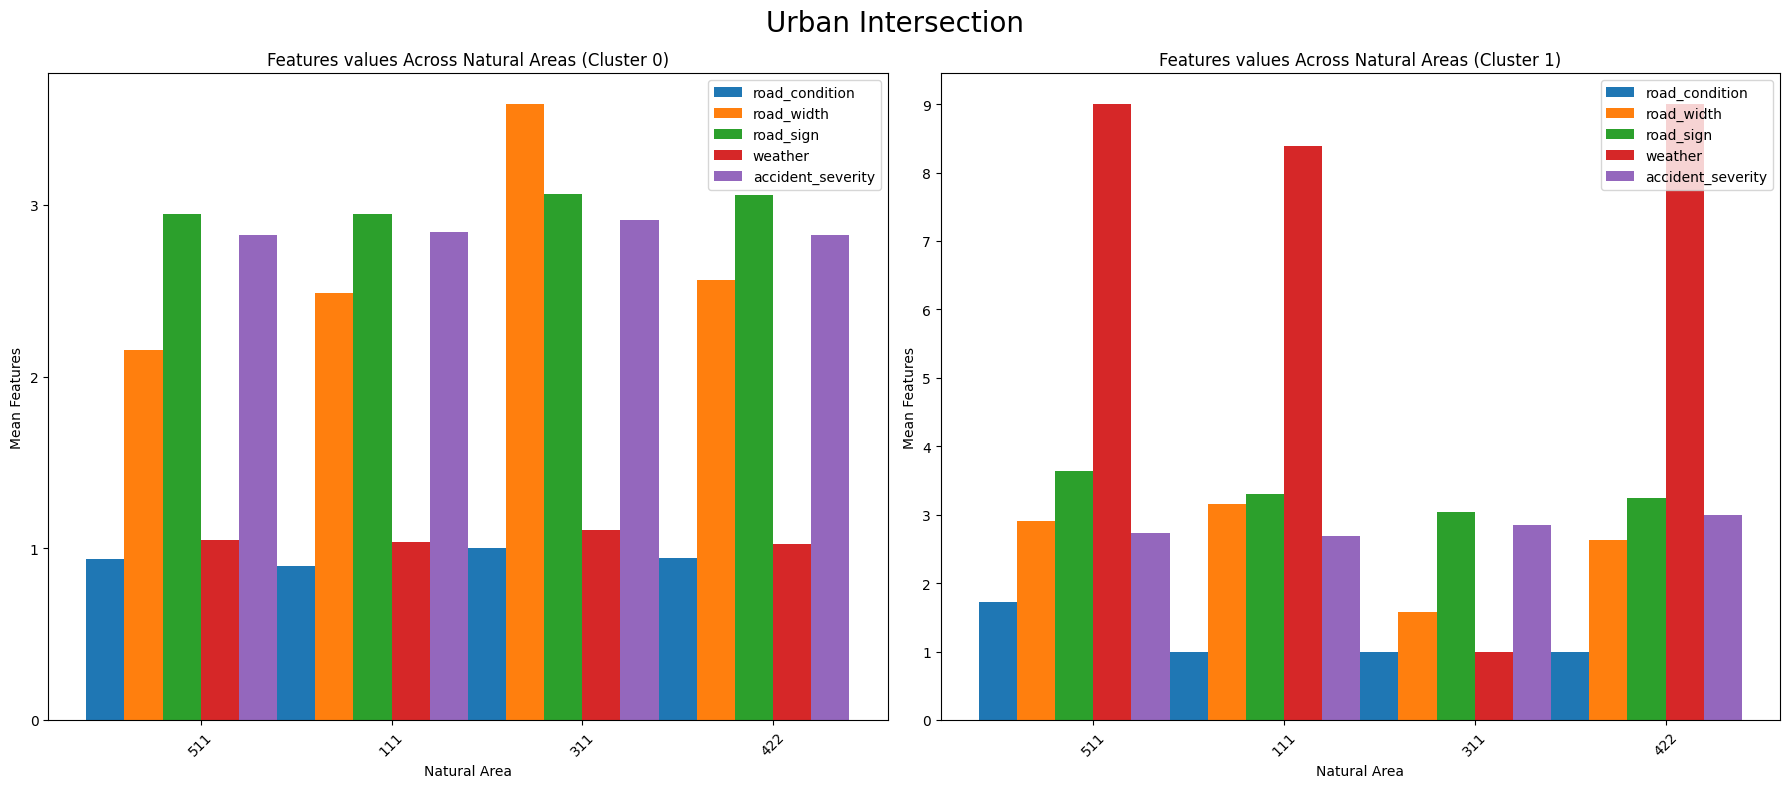

In [48]:
selected_areas = [511, 111, 311, 422]
urban_intersection_data = get_cluster_data(cluster_stats_urban_intersection, [0, 1])
plot_severity_impact(urban_intersection_data, selected_areas, features, 'Urban Intersection')

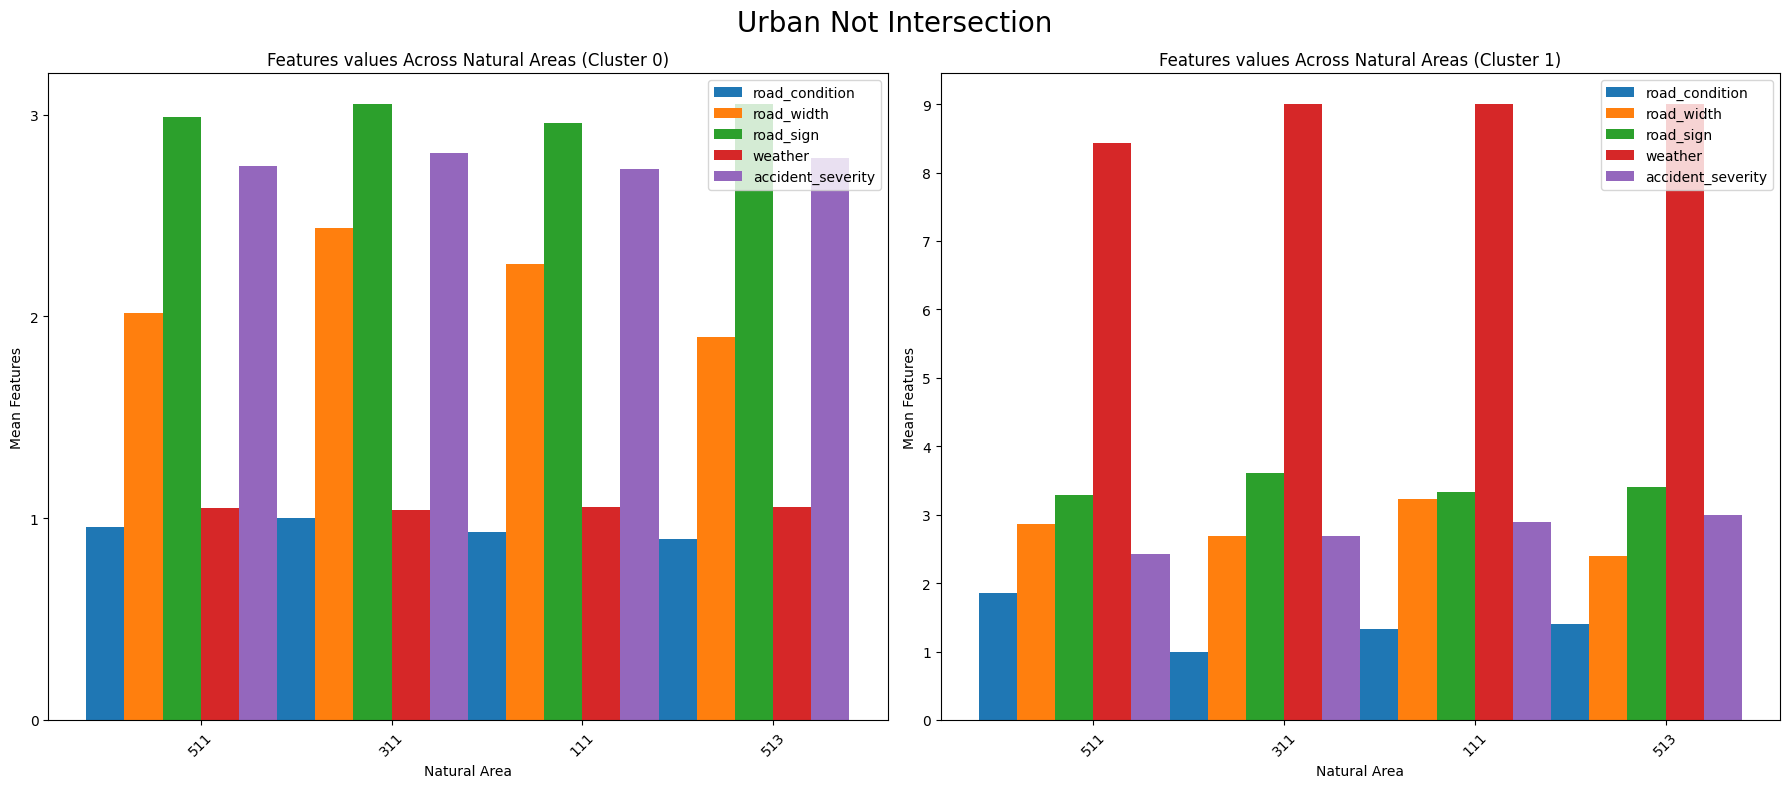

In [49]:
selected_areas = [511, 311, 111, 513]
urban_not_intersection_data = get_cluster_data(cluster_stats_urban_not_intersection, [0, 1])
plot_severity_impact(urban_not_intersection_data, selected_areas, features, 'Urban Not Intersection')

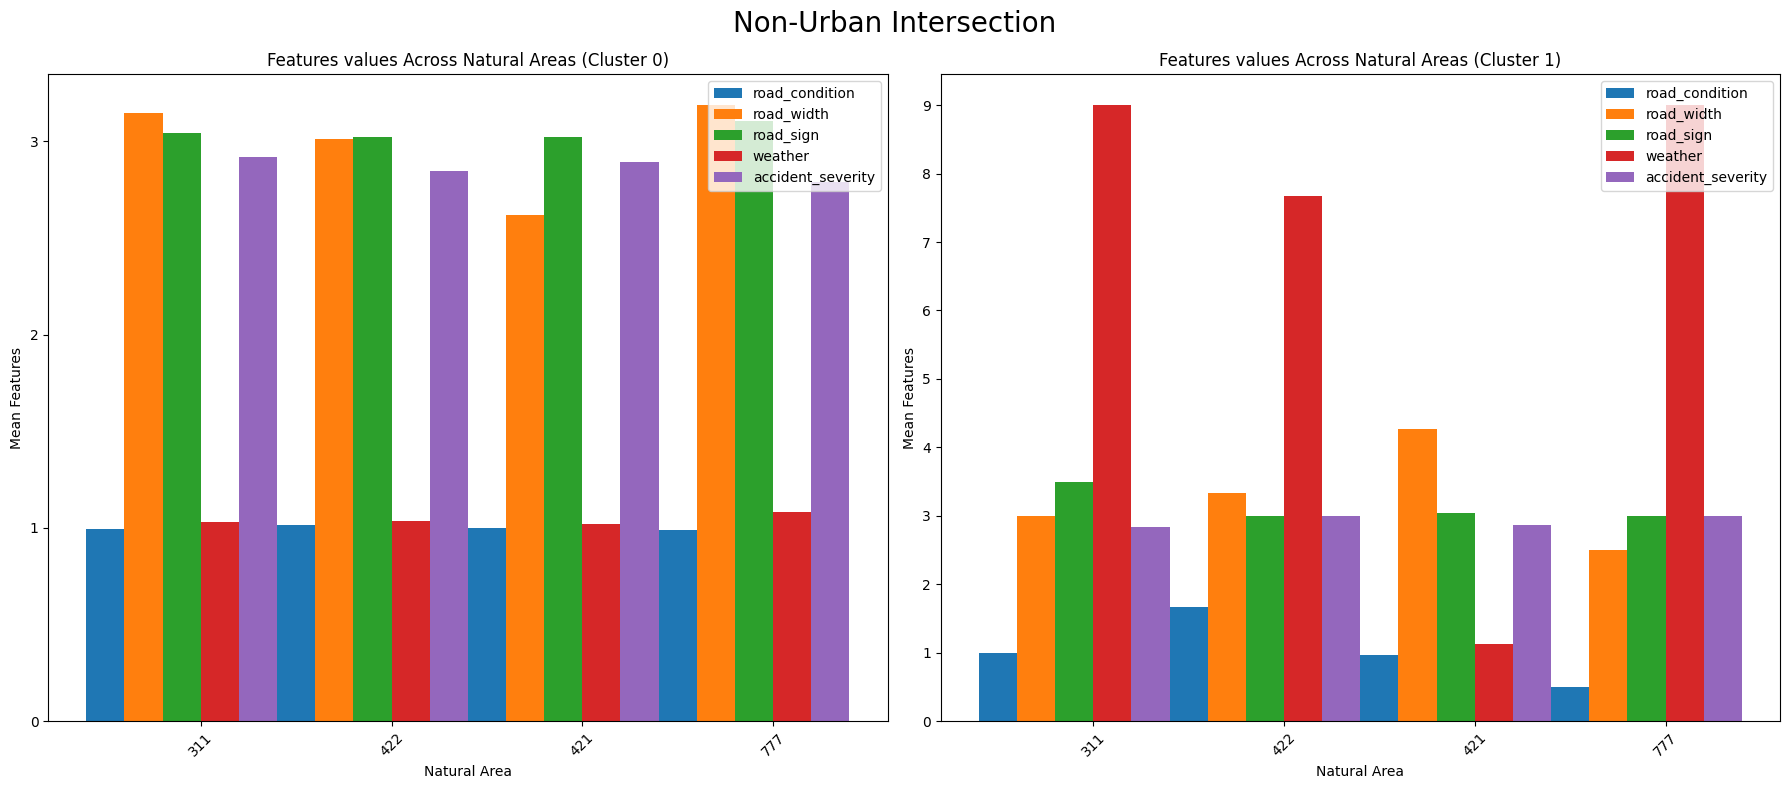

In [50]:
selected_areas = [311, 422, 421, 777]
non_urban_intersection_data = get_cluster_data(cluster_stats_non_urban_intersection, [0, 1])
plot_severity_impact(non_urban_intersection_data, selected_areas, features, 'Non-Urban Intersection')

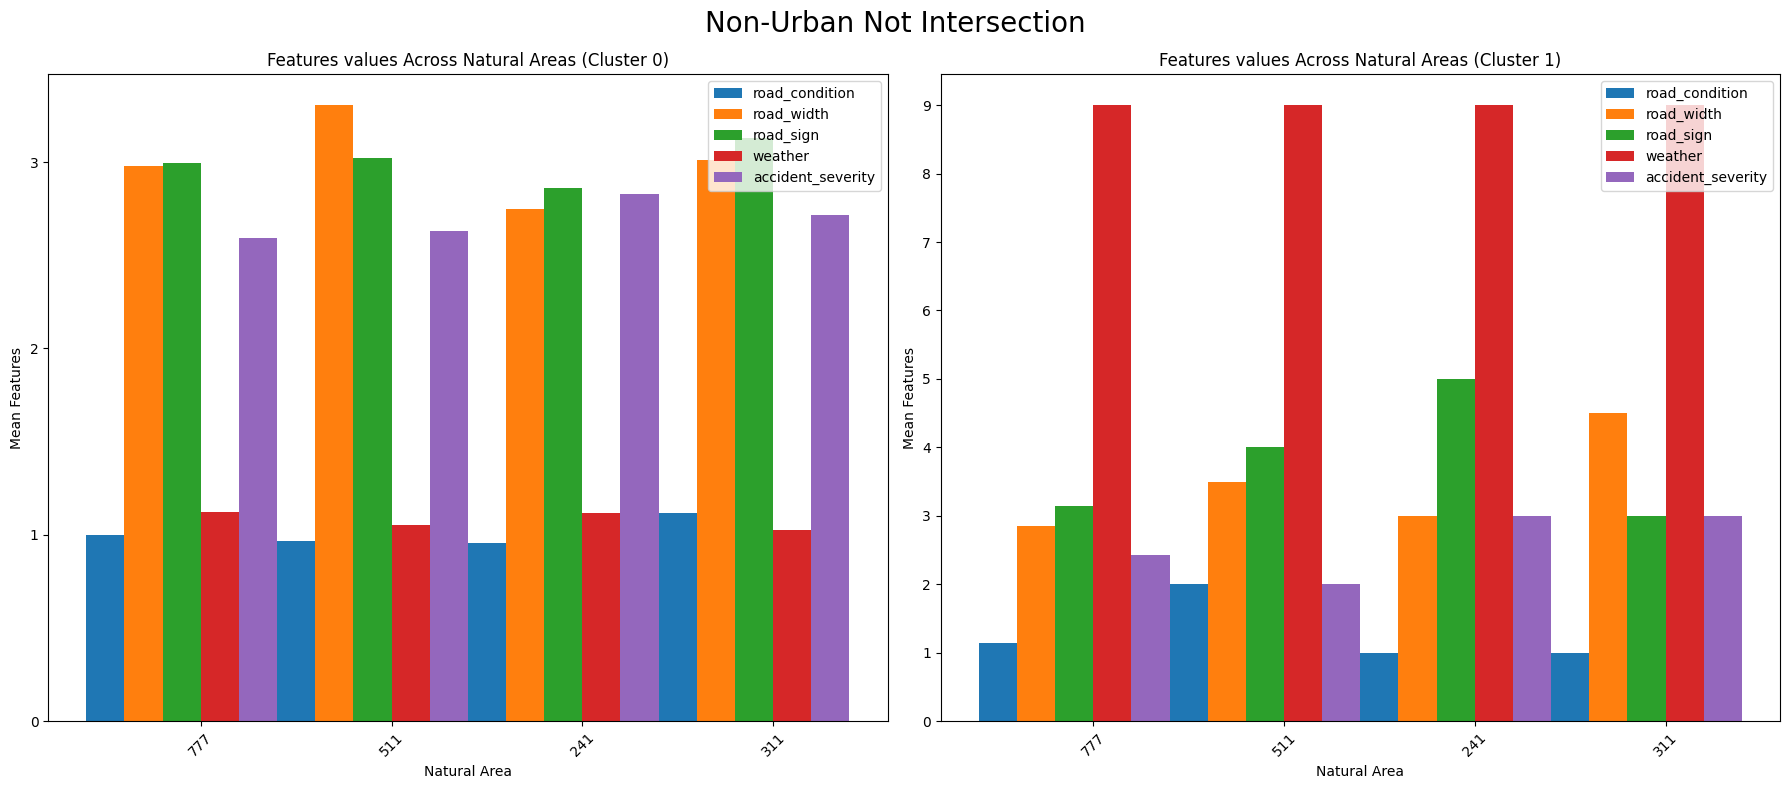

In [51]:
selected_areas = [777, 511, 241, 311]
non_urban_not_intersection_data = get_cluster_data(cluster_stats_non_urban_not_intersection, [0, 1])
plot_severity_impact(non_urban_not_intersection_data, selected_areas, features, 'Non-Urban Not Intersection')